# GUC Clustering Project 

**Objective:** 
The objective of this project teach students how to apply clustering to real data sets

The projects aims to teach student: 
* Which clustering approach to use
* Compare between Kmeans, Hierarchal, DBScan, and Gaussian Mixtures  
* How to tune the parameters of each data approach
* What is the effect of different distance functions (optional) 
* How to evaluate clustering approachs 
* How to display the output
* What is the effect of normalizing the data 

Students in this project will use ready-made functions from Sklearn, plotnine, numpy and pandas 
 



In [1]:
# if plotnine is not installed in Jupter then use the following command to install it 


Running this project require the following imports 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
#from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = ['b','r','g','c','m','y','k','violet','teal','bisque','gold','navy','olive']  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],color = color[i], marker = 'x', s = 100)
        plt.title(f'K-Means Clustering with {num_clusters} Clusters')
        plt.show()

## Multi Blob Data Set 
* The Data Set generated below has 6 cluster with varying number of users and varing densities
* Cluster the data set below using 



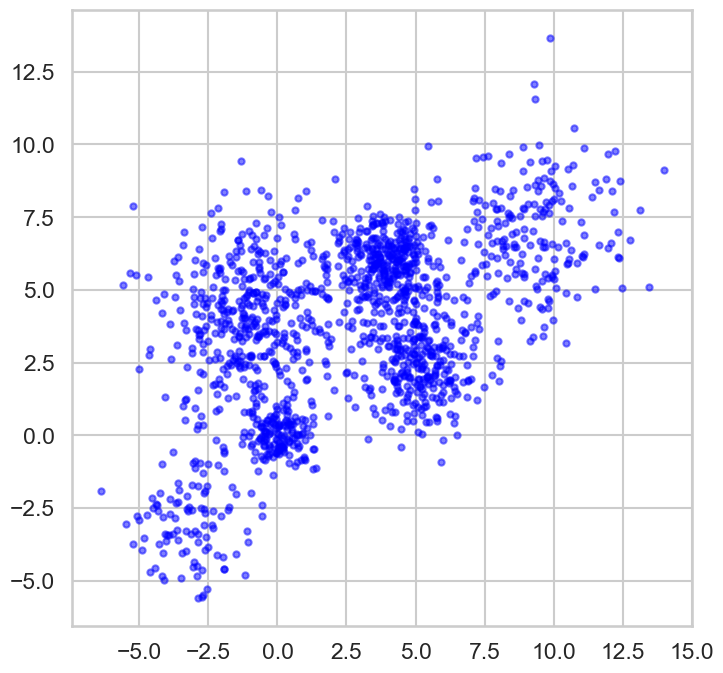

In [4]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)

### Kmeans 
* Use Kmeans with different values of K to cluster the above data 
* Display the outcome of each value of K 
* Plot distortion function versus K and choose the approriate value of k 
* Plot the silhouette_score versus K and use it to choose the best K 
* Store the silhouette_score for the best K for later comparison with other clustering techniques. 

In [5]:
def K_mean_method(X):
    #define a range of values for K to try
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    #create empty lists to store distortion function and silhouette score values
    distortions = []
    silhouettes = []

    #loop over different values of K
    for n_clusters in range_n_clusters:
        #create a k-means object with n_clusters clusters
        kmeans = KMeans(n_clusters=n_clusters)
        
        #fit it to the data and get cluster labels 
        labels = kmeans.fit_predict(X)
        
        #get cluster centroids 
        centroids = kmeans.cluster_centers_
        
        #calculate distortion function (inertia) 
        distortions.append(kmeans.inertia_)
        
        #calculate silhouette score 
        silhouettes.append(silhouette_score(X, labels))
        
        #plot data with cluster labels and centroids 
        plt.figure()
        plt.scatter(X[:, 0], X[:, 1], c=labels)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
        plt.title(f'K-Means Clustering with {n_clusters} clusters')

    #choose appropriate value of K based on elbow method 
    best_k_elbow = range_n_clusters[np.argmin(np.diff(distortions))]
    print(f'The best value of K based on elbow method is {best_k_elbow}')

    #choose best value of K based on highest silhouette score 
    best_k_silhouette = range_n_clusters[np.argmax(silhouettes)]
    print(f'The best value of K based on silhouette score is {best_k_silhouette}')

    #store silhouette score for best value of k for later comparison 
    best_silhouette_score = max(silhouettes)
    print(f'The silhouette score for best value of k is {best_silhouette_score}')

    #plot distortion function versus K 
    plt.figure()
    plt.plot(range_n_clusters, distortions)
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion function')
    plt.title('Elbow method')   

    #plot silhouette score vs K
    plt.figure()
    plt.plot(range_n_clusters, silhouettes)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette method')
    
    #return best silhouette score 
    return best_silhouette_score

The best value of K based on elbow method is 2
The best value of K based on silhouette score is 6
The silhouette score for best value of k is 0.4863587776714135


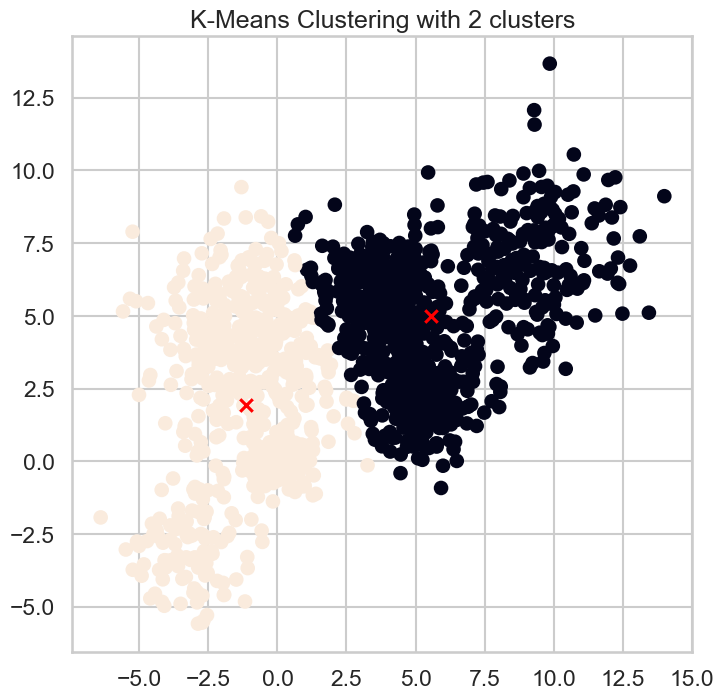

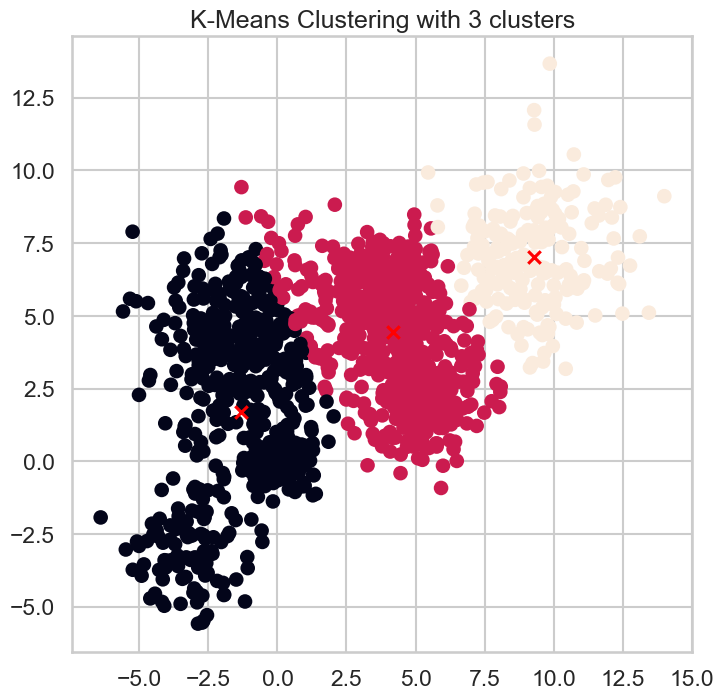

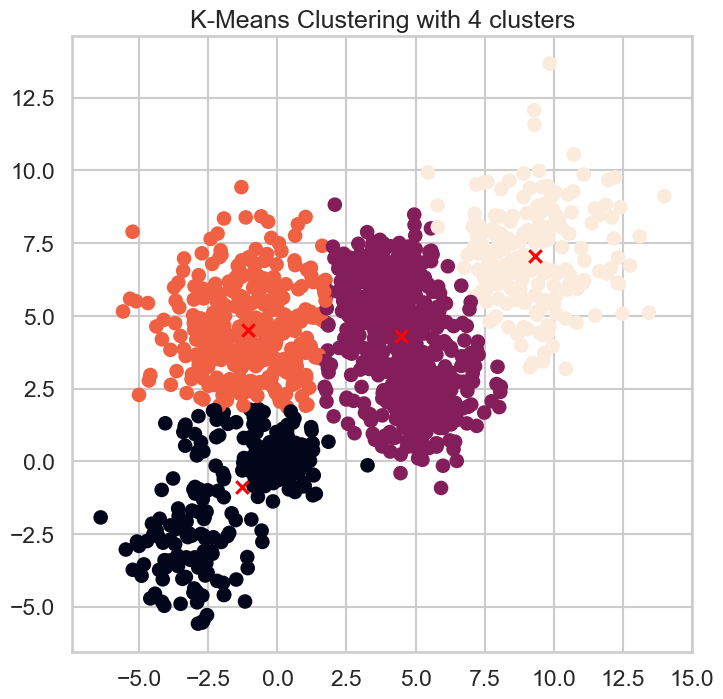

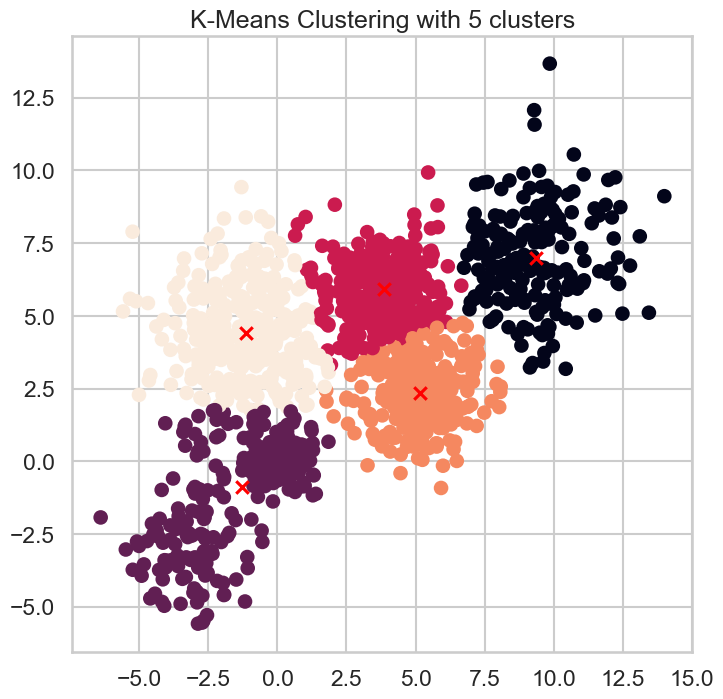

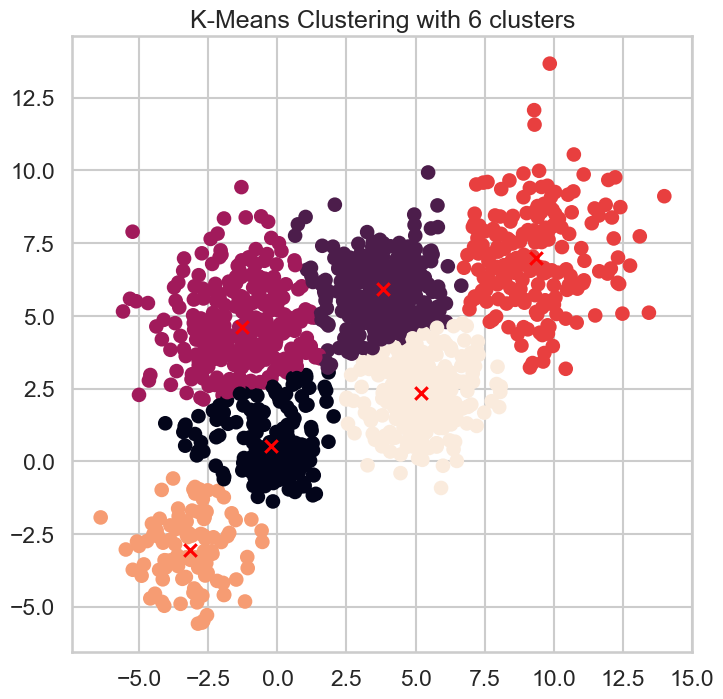

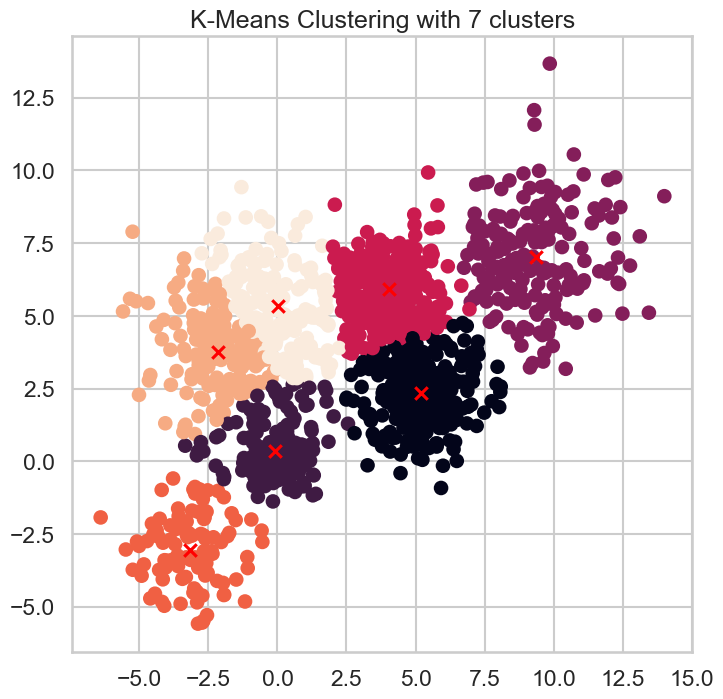

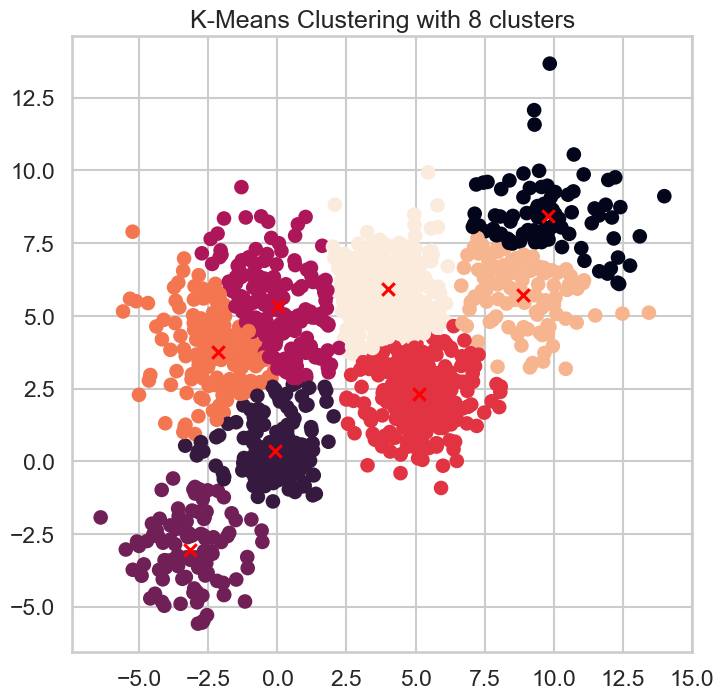

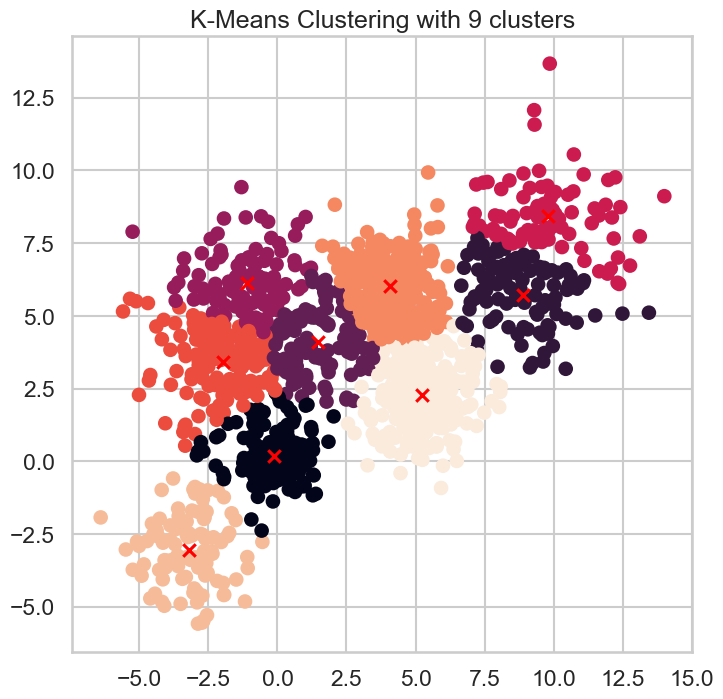

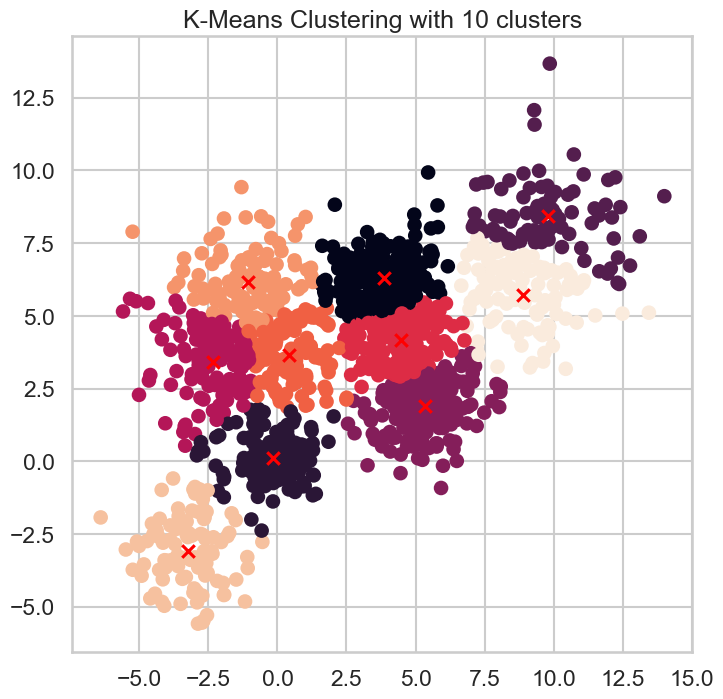

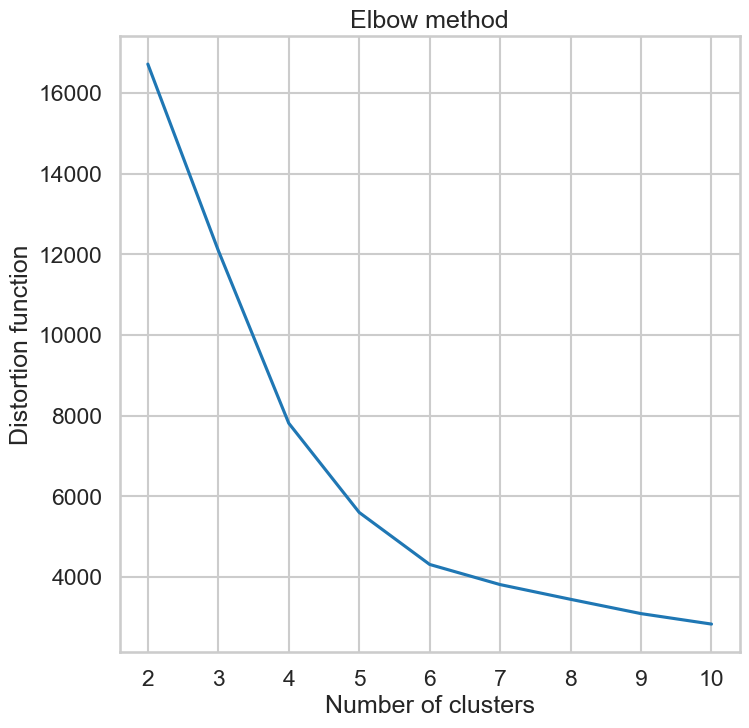

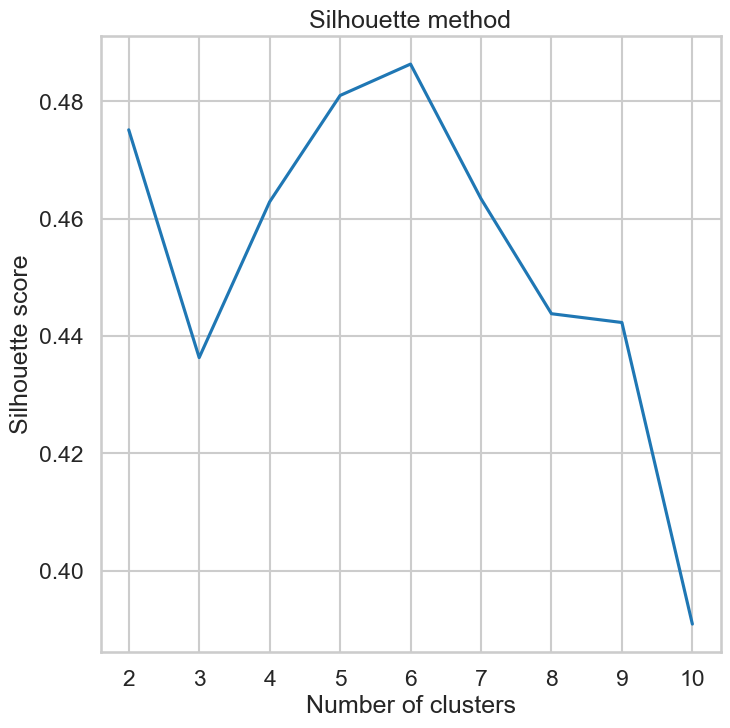

In [6]:
kmean_Multi_blob_Data_silhouette_score = K_mean_method(Multi_blob_Data)

### Hierarchal Clustering
* Use AgglomerativeClustering function to  to cluster the above data 
* In the  AgglomerativeClustering change the following parameters 
    * Affinity (use euclidean, manhattan and cosine)
    * Linkage( use average and single )
    * Distance_threshold (try different)
* For each of these trials plot the Dendograph , calculate the silhouette_score and display the resulting clusters  
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observation 

In [7]:
def dendrogram_plot(model):
    #create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            #Values less than n_samples correspond to leaves of the tree which are the original samples.
            if child_idx < n_samples:
                current_count += 1  # leaf node
            #A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]    
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float)

    # Plot the corresponding dendrogram
    shc.dendrogram(linkage_matrix)

In [8]:
def hierarchial_method(X, affinity, linkage):
    #create variables
    scores=[]
    thresholds=[]
    score_best=-1000
    best_clustering= None
    threshold_best_silhouette=0
    num_clusters=0
    score=-1

    #plot dendrogram
    plt.figure(figsize =(8, 8))
    plt.title(f"{affinity} & {linkage} \n Data Visualize")
    clustering= AgglomerativeClustering(n_clusters = None,affinity=affinity,linkage=linkage, distance_threshold= 0.5)
    dendrogram_plot(clustering.fit(X))

    #cosine and single linkage
    if(affinity=='cosine' and linkage=='single'):
        for i in np.arange(0.0001,0.1,0.0003):
            clustering= AgglomerativeClustering(n_clusters= None,affinity=affinity,linkage=linkage, distance_threshold= i).fit(X)
            
            #check if there is more than one cluster
            if(len(np.unique(clustering.fit_predict(X)))>1):
                score = silhouette_score(X, clustering.labels_, metric='euclidean')
                scores.append(score)
                thresholds.append(i)

                #check if score is better than previous score
                if(score> score_best):
                    threshold_best_silhouette=i
                    score_best=score
                    best_clustering=clustering
            
            #if there is only one cluster, break
            else:
                break

    #if not cosine and complete linkage
    else:
        for i in np.arange(0.1,5,0.1):
            clustering= AgglomerativeClustering(n_clusters= None,affinity=affinity,linkage=linkage, distance_threshold= i).fit(X)
            
            #check if there is more than one cluster
            if(len(np.unique(clustering.fit_predict(X)))>1):
                score = silhouette_score(X, clustering.labels_, metric='euclidean')
                scores.append(score)
                thresholds.append(i)

                #check if score is better than previous score
                if(score> score_best):
                    threshold_best_silhouette=i
                    score_best=score
                    best_clustering=clustering

            #if there is only one cluster, break
            else:
                break
        
    #if there is a best clustering, get labels and number of clusters    
    if(best_clustering!= None):
        labels=best_clustering.labels_
        num_clusters= best_clustering.n_clusters_

        #plot data with cluster labels and centroids
        if(len(X[0])<=2):
            plt.figure()
            plt.title(f"{affinity} & {linkage} \n Num clusters = {num_clusters} & Optimum distance threshold = {threshold_best_silhouette}")
            plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.viridis)
            plt.show()
    
    print("Optimum distance threshold =" , threshold_best_silhouette)
    print("Number of Clusters =" , num_clusters)
    print("Score =" , score)
    
    #Plotting
    plt.figure()   
    plt.plot(thresholds,scores, 'bx-')
    plt.ylabel("Silhouette Score")
    plt.xlabel("Values of Distance Thresholds")
    plt.title(f"{affinity} & {linkage} \n Silhouette Score vs Distance Thresholds")
    plt.show()  

    return score, num_clusters, threshold_best_silhouette 

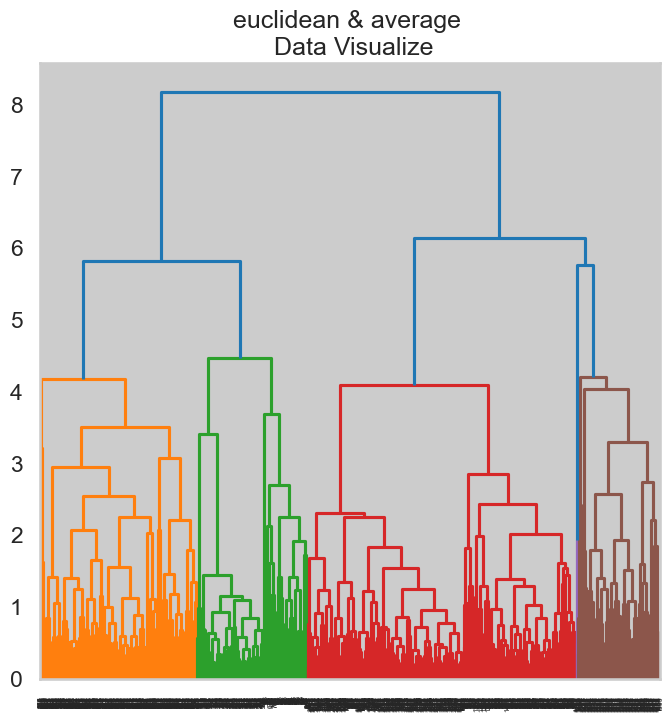

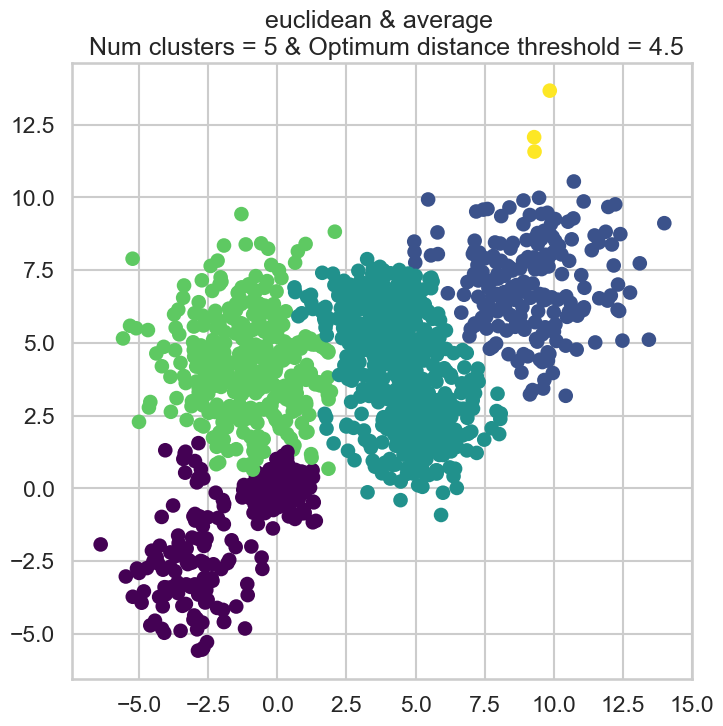

Optimum distance threshold = 4.5
Number of Clusters = 5
Score = 0.433187948807373


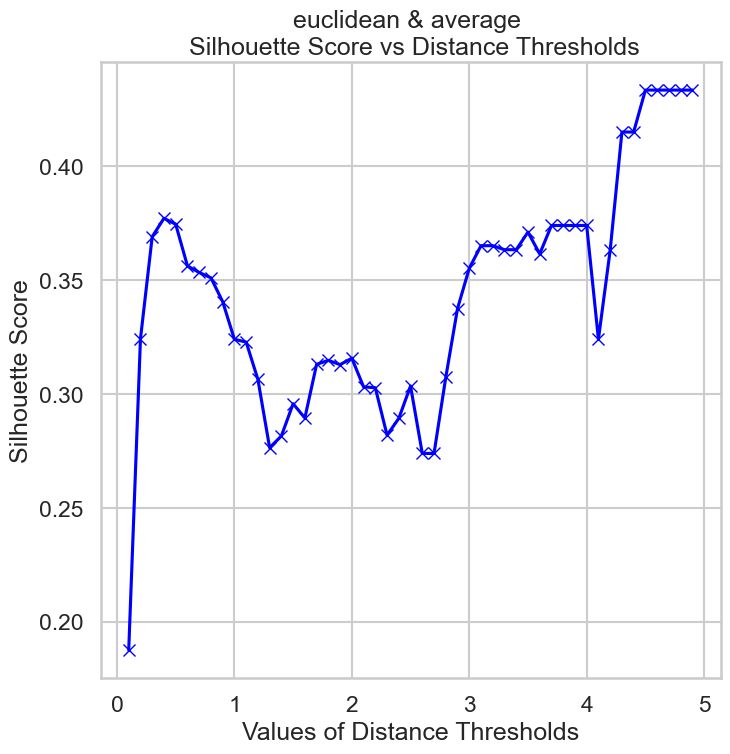

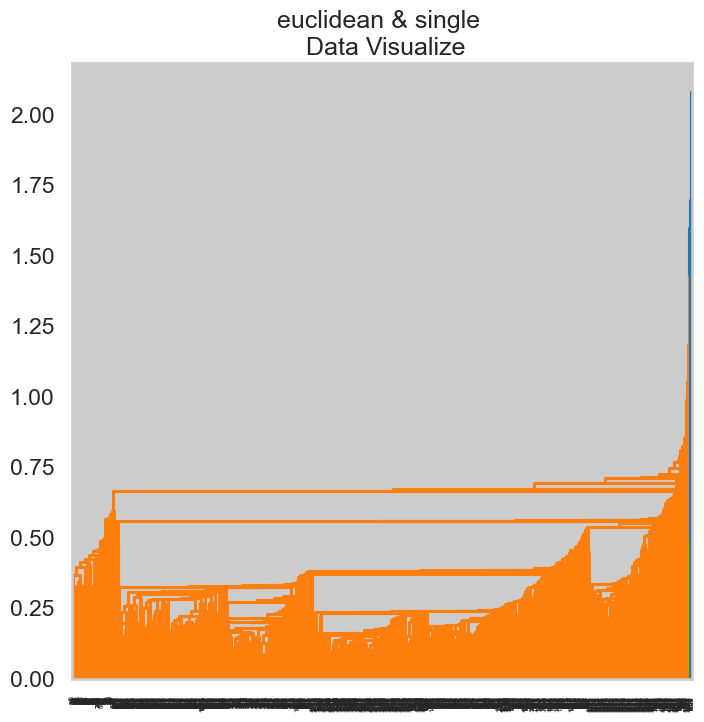

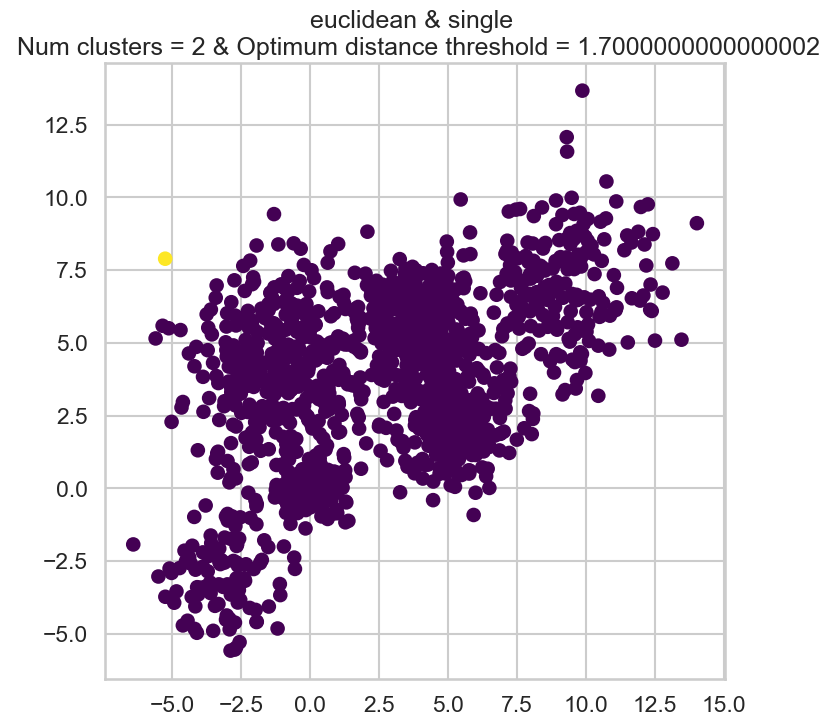

Optimum distance threshold = 1.7000000000000002
Number of Clusters = 2
Score = 0.3218066204847175


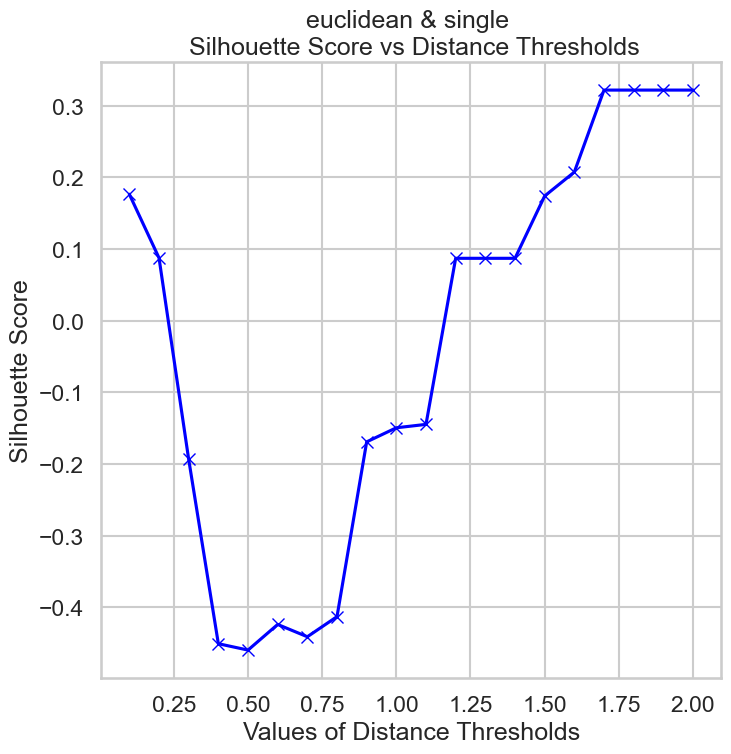

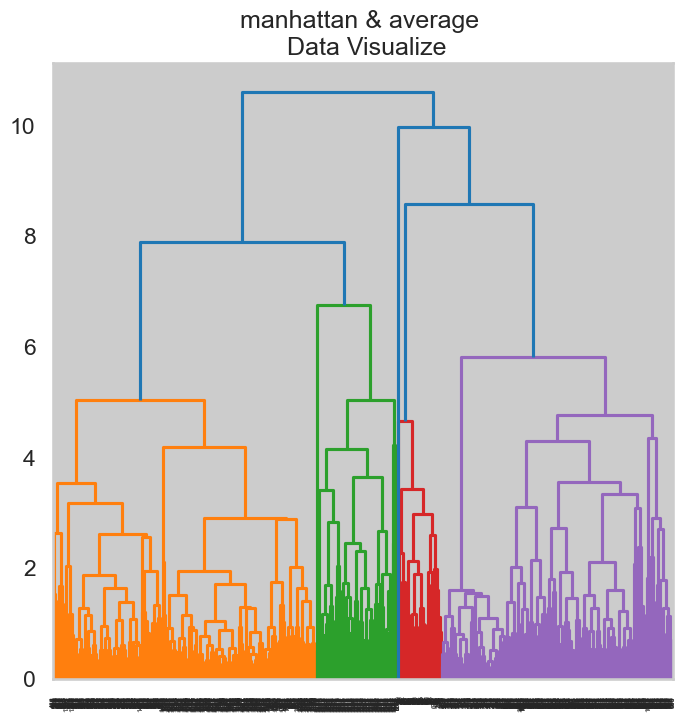

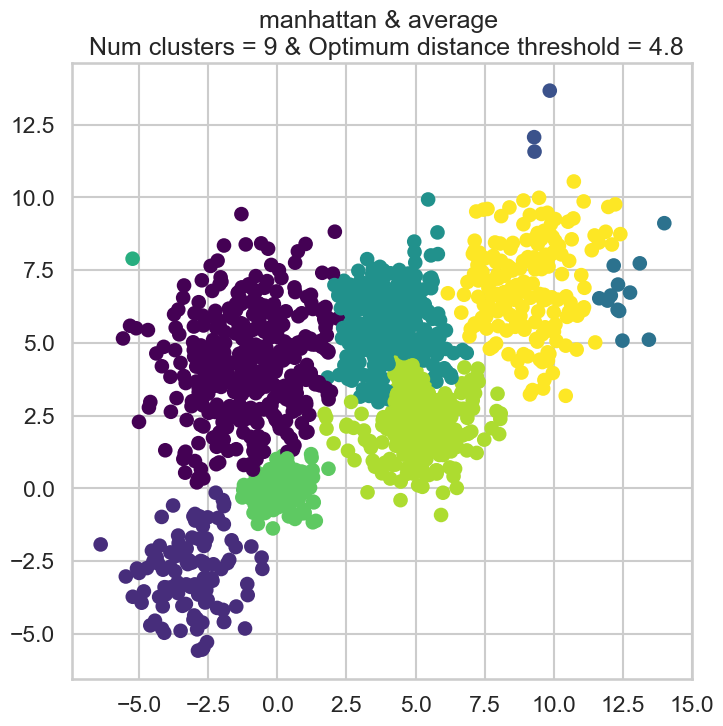

Optimum distance threshold = 4.8
Number of Clusters = 9
Score = 0.399558543983381


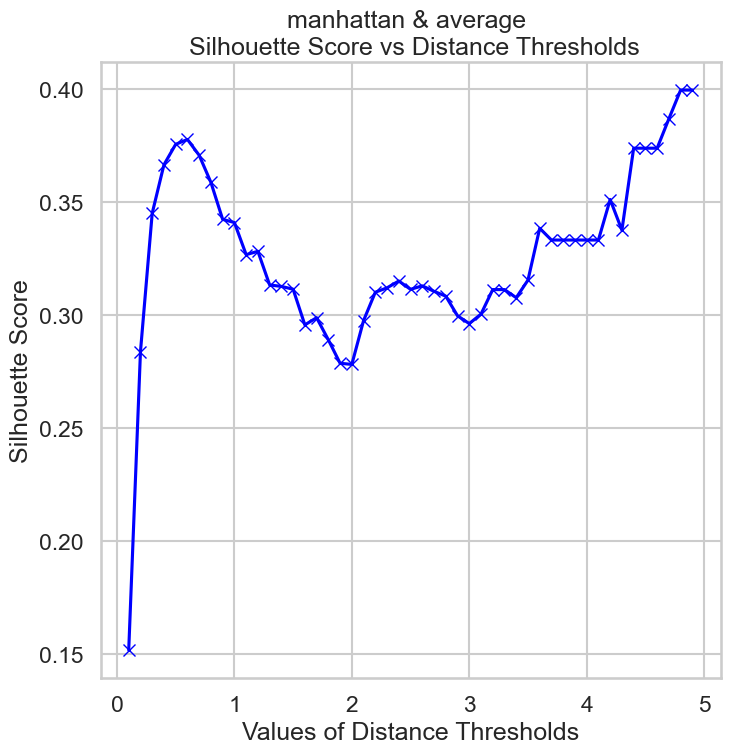

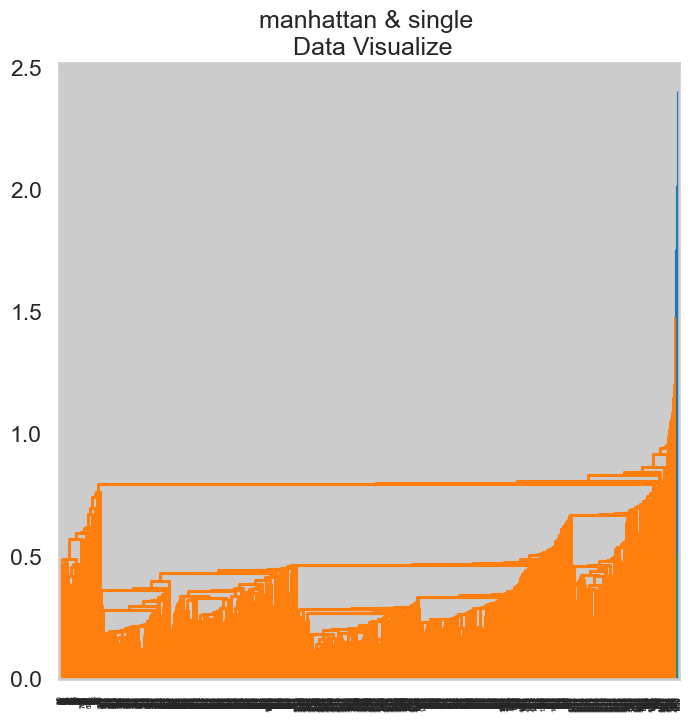

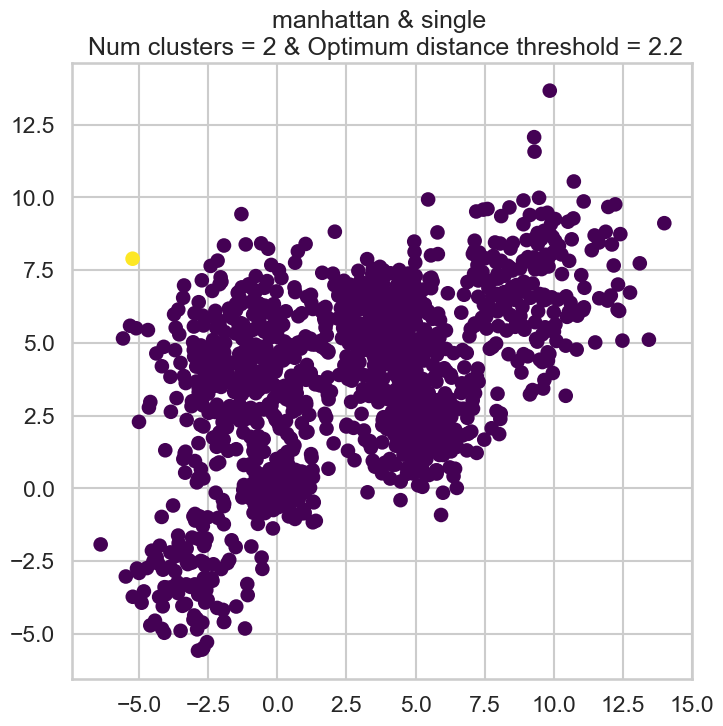

Optimum distance threshold = 2.2
Number of Clusters = 2
Score = 0.3218066204847175


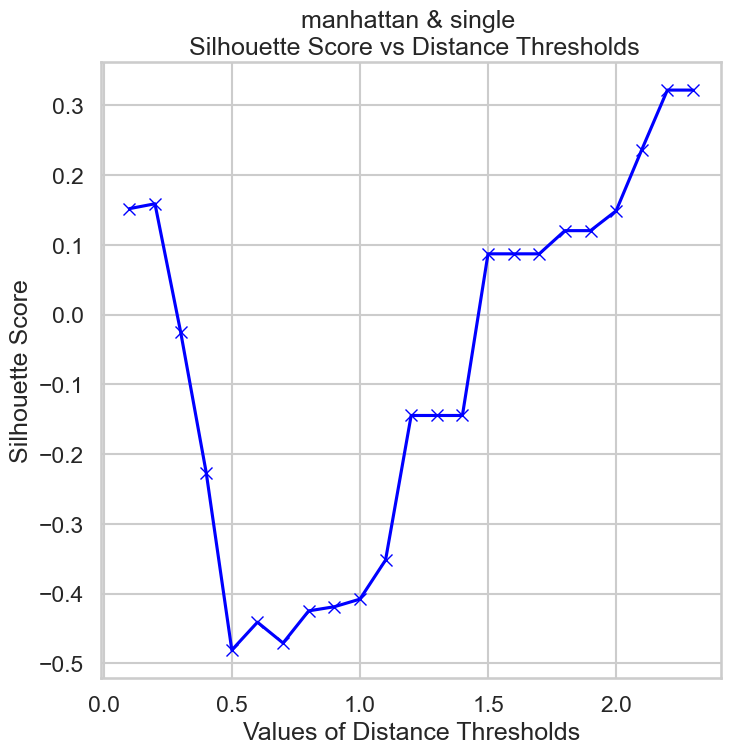

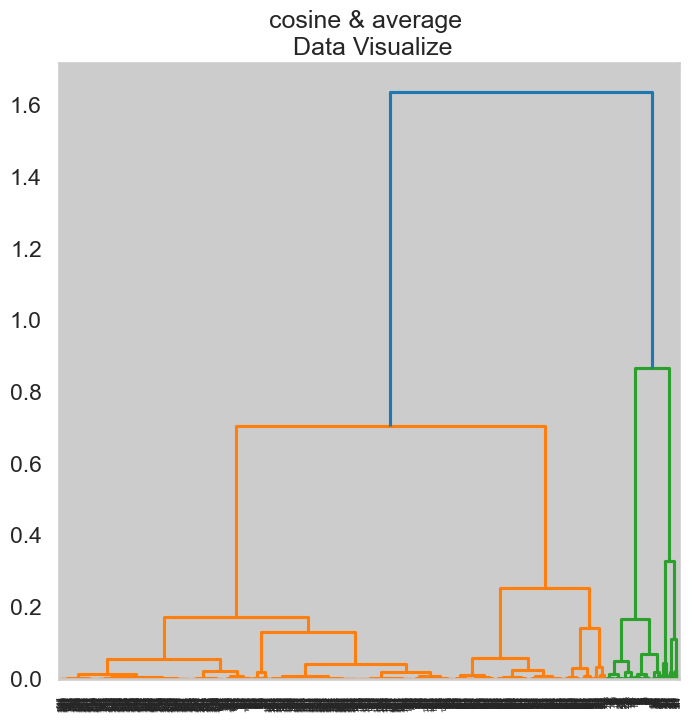

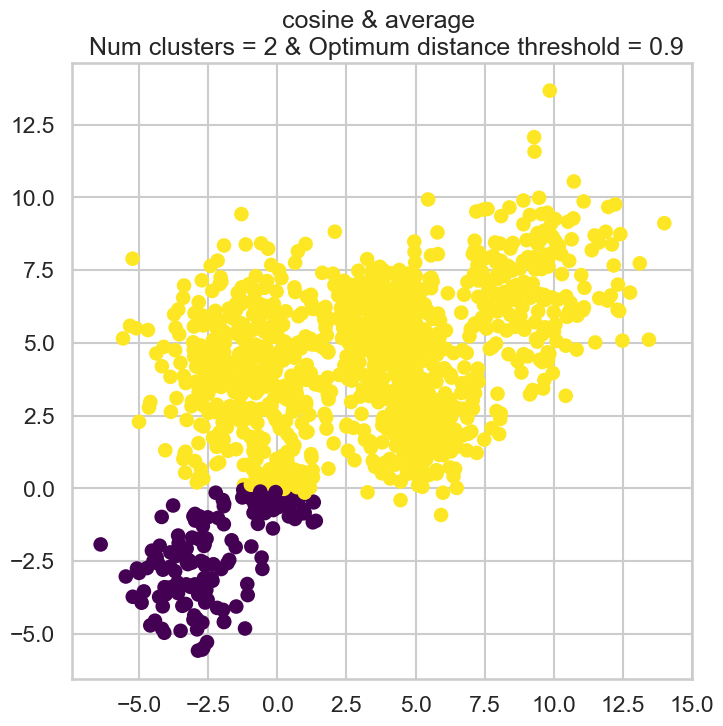

Optimum distance threshold = 0.9
Number of Clusters = 2
Score = 0.35251834131557364


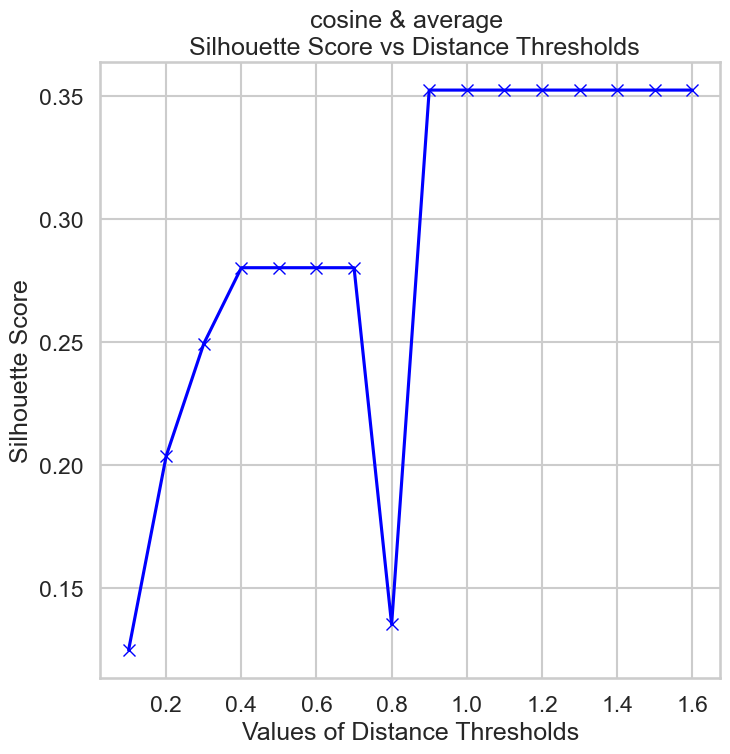

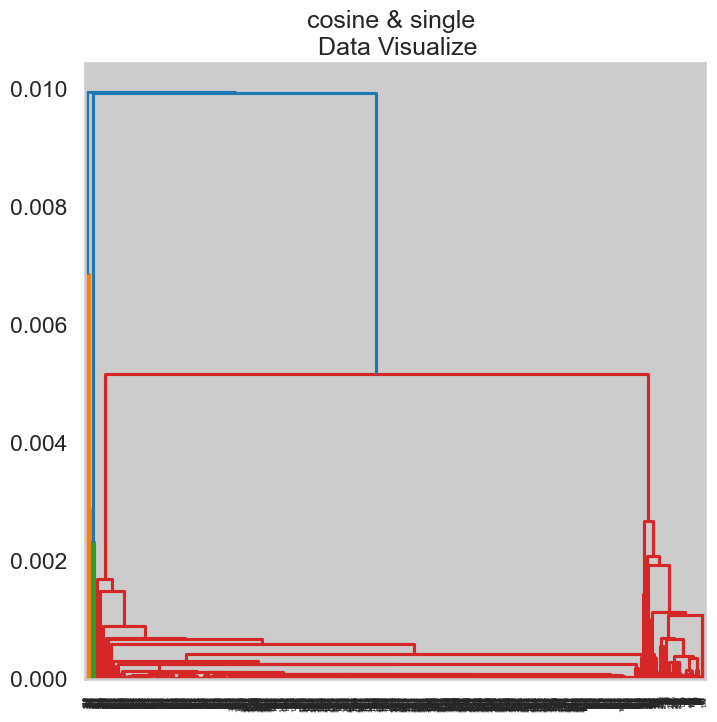

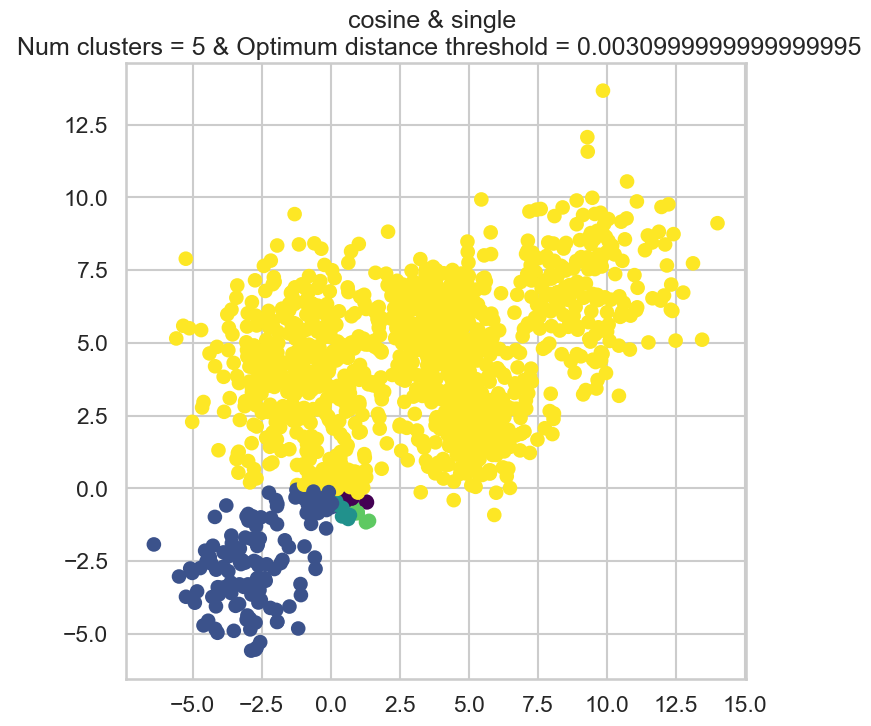

Optimum distance threshold = 0.0030999999999999995
Number of Clusters = 5
Score = -0.027300281882024397


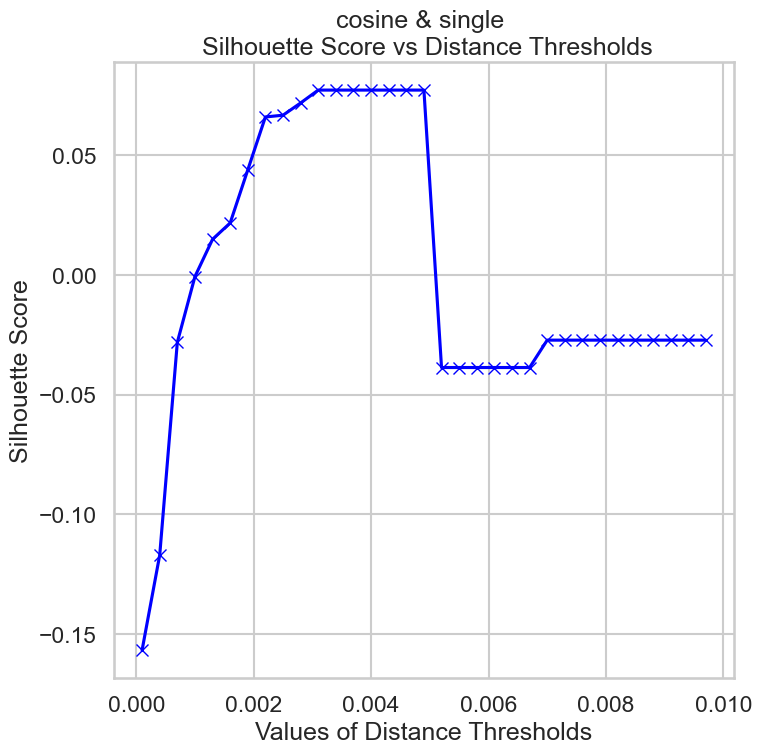

In [9]:
#euclidean & average
[hierarchial_Multi_blob_Data_score1, hierarchial_Multi_blob_Data_cluster1, hierarchial_Multi_blob_Data_best_silhouette1] = hierarchial_method(Multi_blob_Data, "euclidean", "average")

#euclidean & single
[hierarchial_Multi_blob_Data_score2, hierarchial_Multi_blob_Data_cluster2, hierarchial_Multi_blob_Data_best_silhouette2] = hierarchial_method(Multi_blob_Data, "euclidean", "single")

#manhattan & average
[hierarchial_Multi_blob_Data_score3, hierarchial_Multi_blob_Data_cluster3, hierarchial_Multi_blob_Data_best_silhouette3] = hierarchial_method(Multi_blob_Data, "manhattan", "average")

#manhattan & single
[hierarchial_Multi_blob_Data_score4, hierarchial_Multi_blob_Data_cluster4, hierarchial_Multi_blob_Data_best_silhouette4] = hierarchial_method(Multi_blob_Data, "manhattan", "single")

#cosine & average
[hierarchial_Multi_blob_Data_score5, hierarchial_Multi_blob_Data_cluster5, hierarchial_Multi_blob_Data_best_silhouette5] = hierarchial_method(Multi_blob_Data, "cosine", "average")

#cosine & single
[hierarchial_Multi_blob_Data_score6, hierarchial_Multi_blob_Data_cluster6, hierarchial_Multi_blob_Data_best_silhouette6] = hierarchial_method(Multi_blob_Data, "cosine", "single")

### DBScan
* Use DBScan function to  to cluster the above data 
* In the  DBscan change the following parameters 
    * EPS (from 0.1 to 3)
    * Min_samples (from 5 to 25)
* Plot the silhouette_score versus the variation in the EPS and the min_samples
* Plot the resulting Clusters in this case 
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observations and comments 

In [10]:
def DBScan_method(X):
    # Initialize lists to store scores and parameters
    scores = []
    eps_list = []
    min_samples_list = []

    # Loop over different values of eps and min_samples
    for eps in np.arange(start=0.1, stop=3.1, step=0.1):
        for min_samples in range(5, 26):
            # Perform DBSCAN clustering
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            # Get cluster labels
            labels = db.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # exclude noise points
            if n_clusters > 1:
                # Calculate silhouette score
                score = silhouette_score(X, labels)
                # Append score and parameters to lists
                scores.append(score)
                eps_list.append(eps)
                min_samples_list.append(min_samples)
            else:
                break

    if(len(scores)>0):
        # Plot silhouette score versus eps and min_samples
        plt.scatter(eps_list, min_samples_list, c=scores, cmap='viridis')
        plt.xlabel('EPS')
        plt.ylabel('Min samples')
        plt.title('Silhouette score for DBSCAN')
        plt.colorbar()
        plt.show()
    
        # Find the best score and parameters
        best_index = np.argmax(scores)
        best_score = scores[best_index]
        best_eps = eps_list[best_index]
        best_min_samples = min_samples_list[best_index]

        # Print the best score and parameters
        print(f'The best silhouette score is {best_score:.3f} with eps={best_eps:.1f} and min_samples={best_min_samples}')

        # Plot the resulting clusters with the best parameters
        db_best = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)
        labels_best = db_best.labels_
        plt.scatter(X[:, 0], X[:, 1], c=labels_best, cmap='rainbow')
        # plt.xlabel('X1')
        # plt.ylabel('X2')
        plt.title(f'Clusters with eps={best_eps:.1f} and min_samples={best_min_samples}')
        plt.show()
    else:
        print("No clusters found")


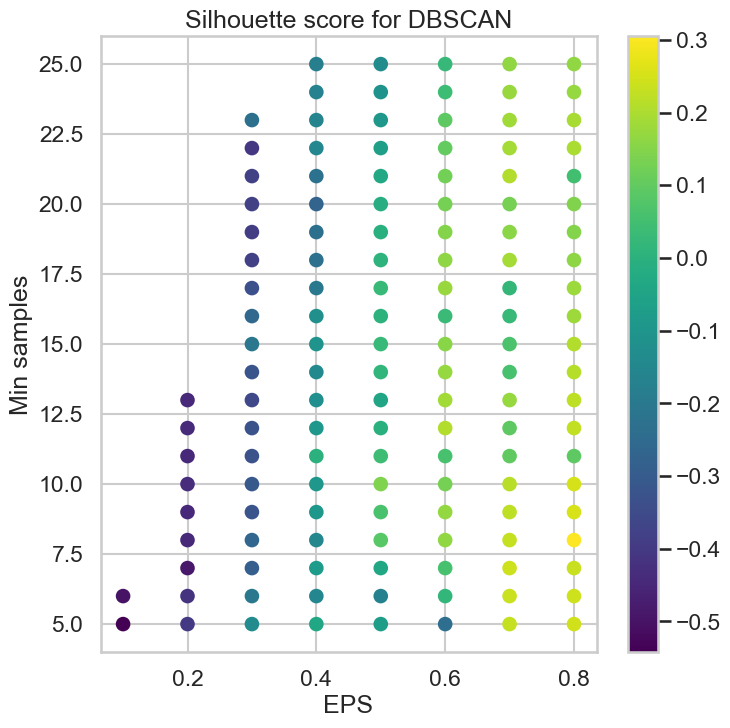

The best silhouette score is 0.305 with eps=0.8 and min_samples=8


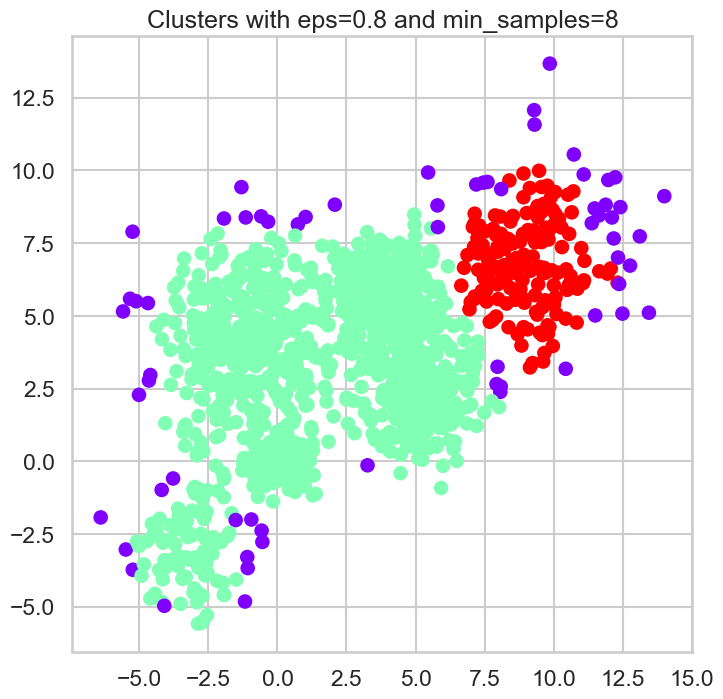

In [11]:
DBScan_method(Multi_blob_Data)

### Gaussian Mixture
* Use GaussianMixture function to cluster the above data 
* In GMM change the covariance_type and check the difference in the resulting proabability fit 
* Use a 2D contour plot to plot the resulting distribution (the components of the GMM) as well as the total Gaussian mixture 

In [12]:
def gaussian_method(X):
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    n_components_range = range(2, 15)
    bic_scores = {}
    best_gmm = {}
    
    for covariance_type in covariance_types:
        bic_scores[covariance_type] = []
        best_bic = np.inf
        best_n_components = None
        
        for n_components in n_components_range:
            # Fit a Gaussian Mixture Model with n_components and covariance_type
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
            gmm.fit(X)

            # Compute the BIC score
            bic = gmm.bic(X)
            bic_scores[covariance_type].append(bic)
            
            # Update the best model if this model has a lower BIC score
            if bic < best_bic:
                best_bic = bic
                best_n_components = n_components
                best_gmm[covariance_type] = gmm
                
        if(len(X[0])<=2):
            # Plot the best model for this covariance_type
            plt.figure(figsize=(8, 6))
            plt.scatter(X[:, 0], X[:, 1], c=best_gmm[covariance_type].predict(X))
            x = np.linspace(X[:, 0].min(), X[:, 0].max())
            y = np.linspace(X[:, 1].min(), X[:, 1].max())
            X_grid, Y_grid = np.meshgrid(x, y)
            XY = np.array([X_grid.ravel(), Y_grid.ravel()]).T
            Z = best_gmm[covariance_type].score_samples(XY).reshape(X_grid.shape)
            plt.contour(X_grid, Y_grid, Z)
            plt.title(f'GMM with {best_n_components} components and {covariance_type} covariance')
            plt.show()
        
    # Plot the BIC scores for each n_components and covariance_type
    plt.figure(figsize=(8, 6))
    for covariance_type in covariance_types:
        plt.plot(list(n_components_range), bic_scores[covariance_type], label=covariance_type)
    plt.legend()
    plt.xlabel('Number of components')
    plt.ylabel('BIC score')
    plt.title('BIC scores for different numbers of components and covariance types')
    plt.show()


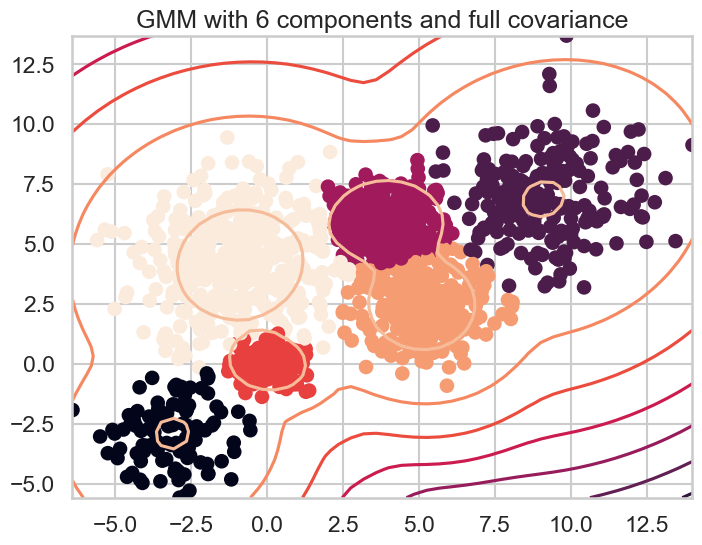

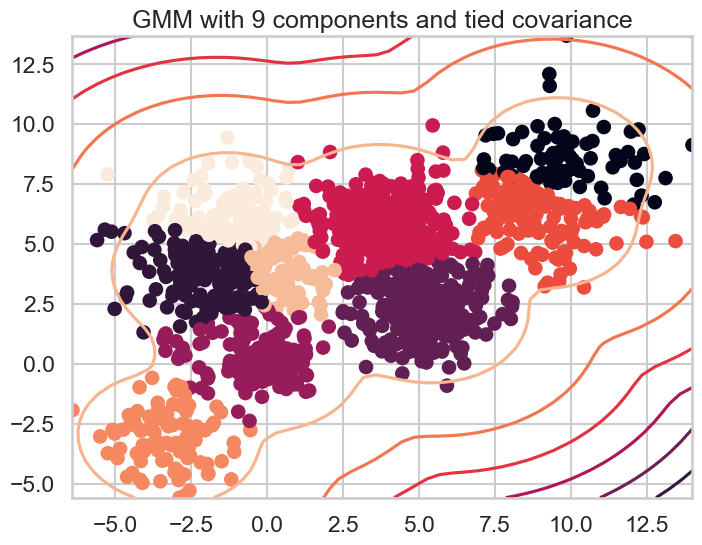

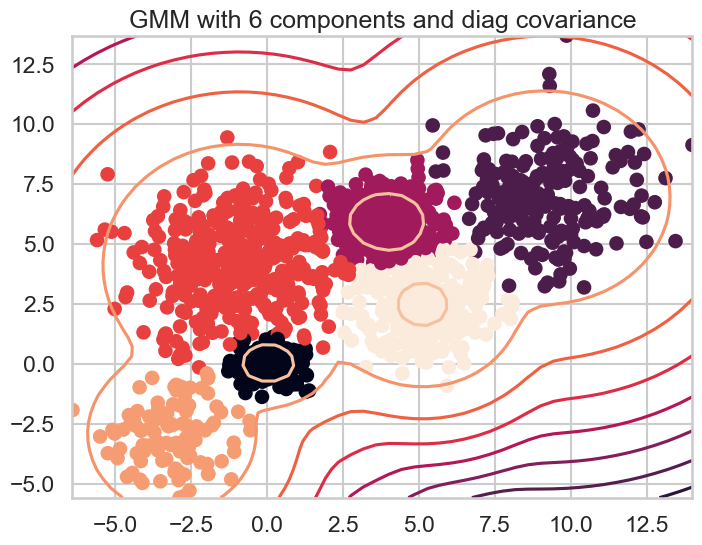

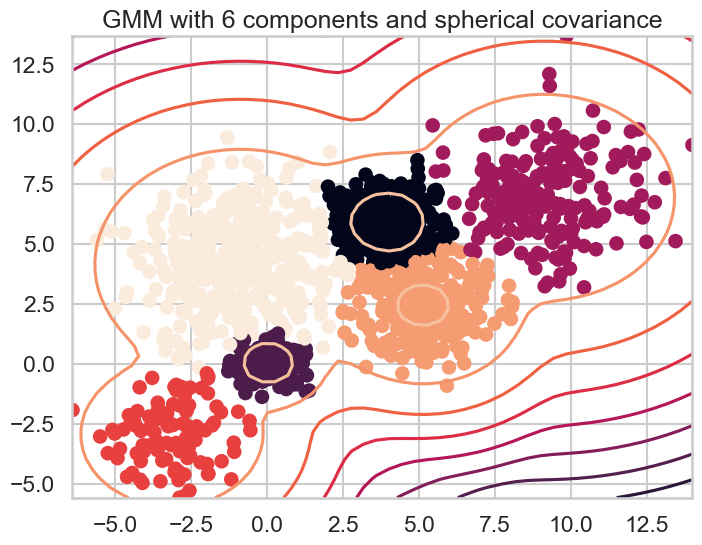

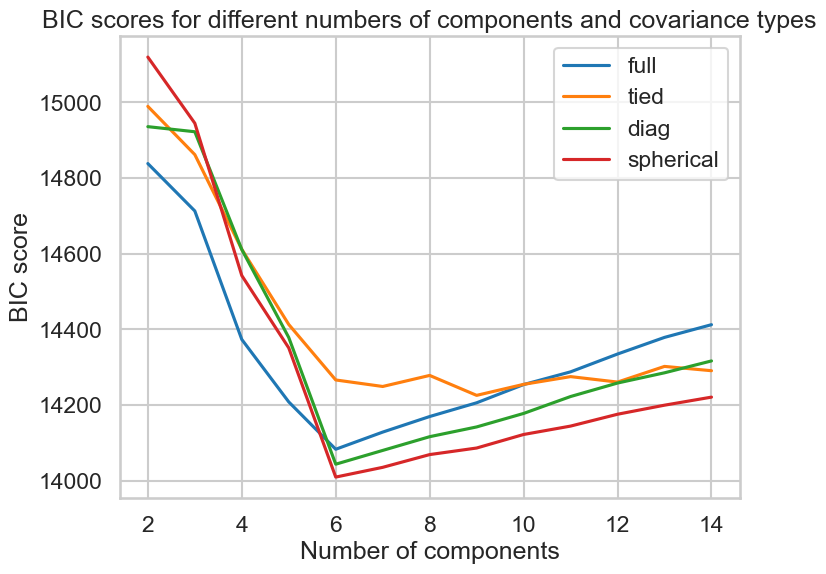

In [13]:
gaussian_method(Multi_blob_Data)

## iris data set 
The iris data set is test data set that is part of the Sklearn module 
which contains 150 records each with 4 features. All the features are represented by real numbers 

The data represents three classes 


In [14]:
from sklearn.datasets import load_iris
iris_data = load_iris()
iris_data.target[[10, 25, 50]]
#array([0, 0, 1])
list(iris_data.target_names)
['setosa', 'versicolor', 'virginica']


['setosa', 'versicolor', 'virginica']

* Repeat all the above clustering approaches and steps on the above data 
* Normalize the data then repeat all the above steps 
* Compare between the different clustering approaches 

### Kmeans

The best value of K based on elbow method is 2
The best value of K based on silhouette score is 2
The silhouette score for best value of k is 0.6810461692117462


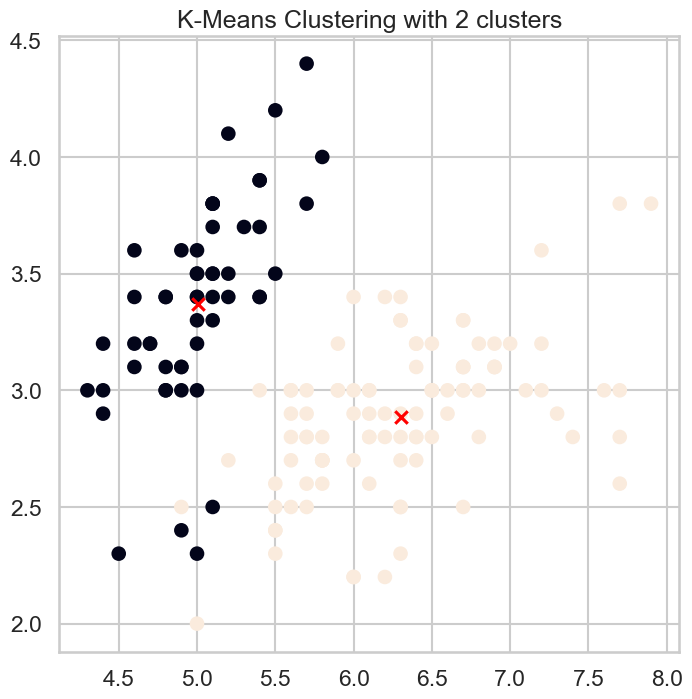

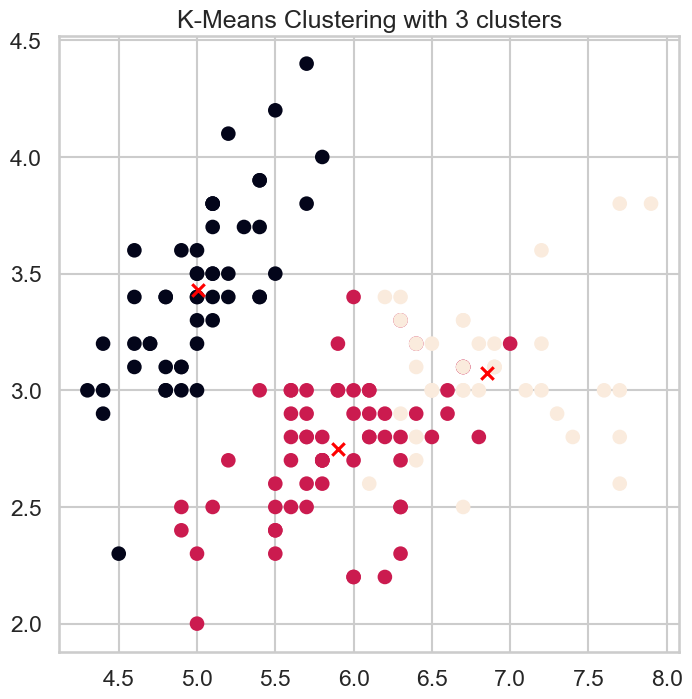

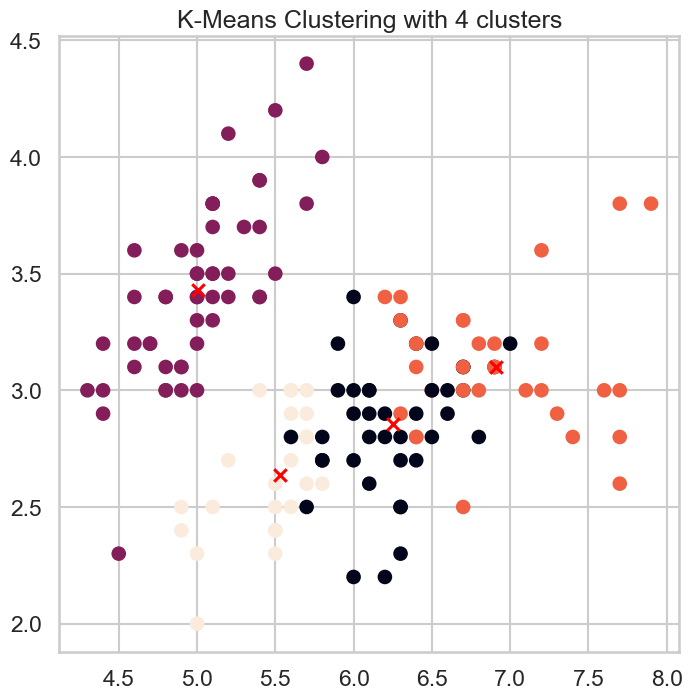

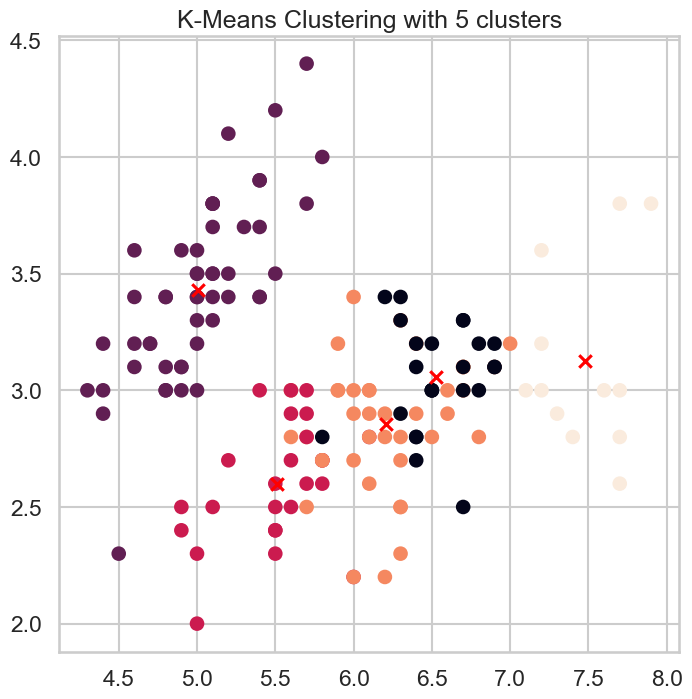

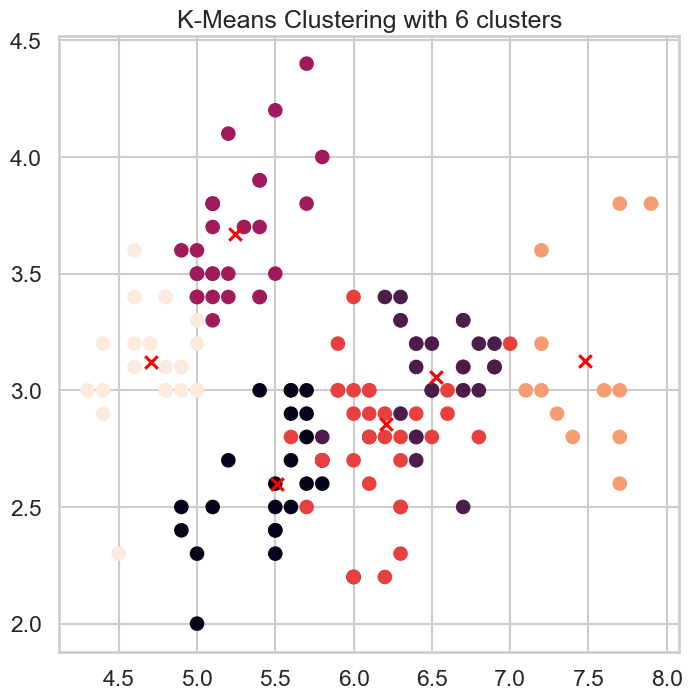

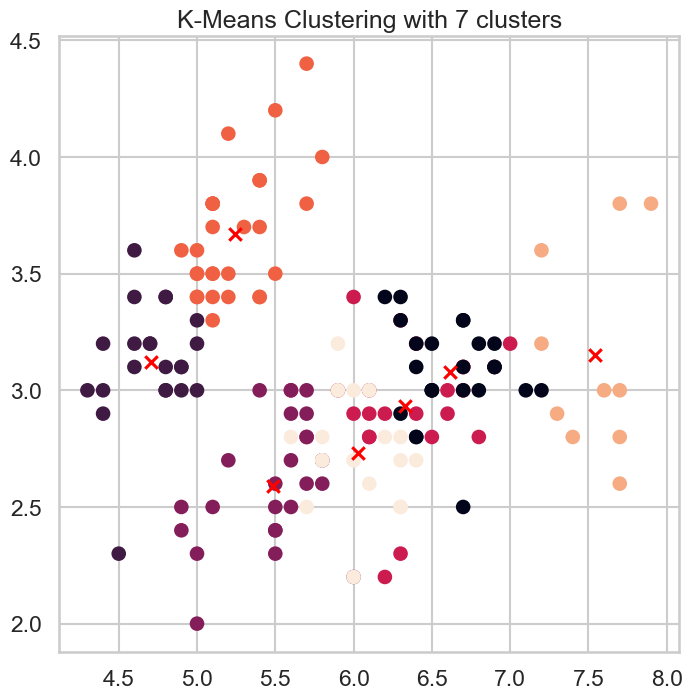

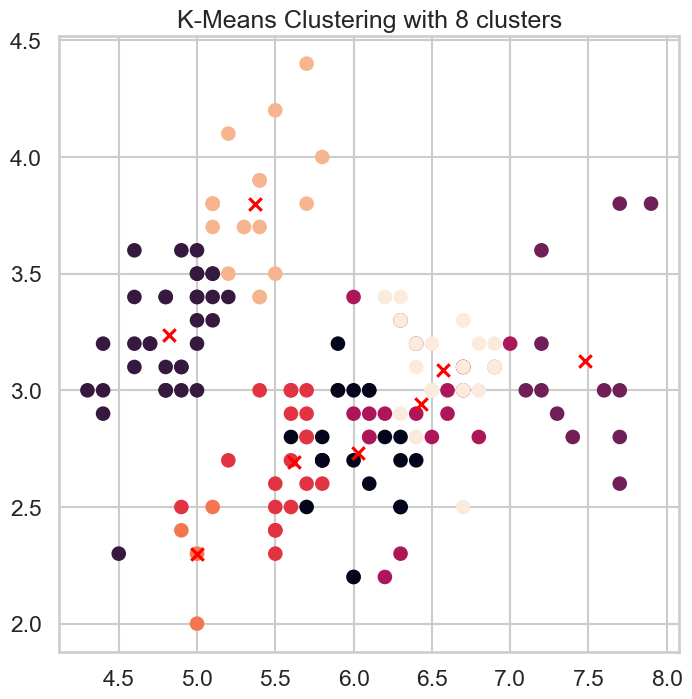

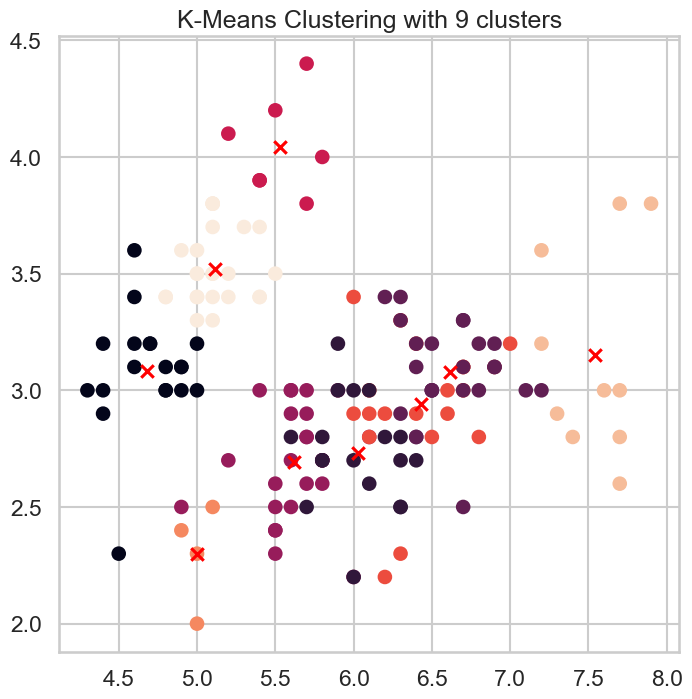

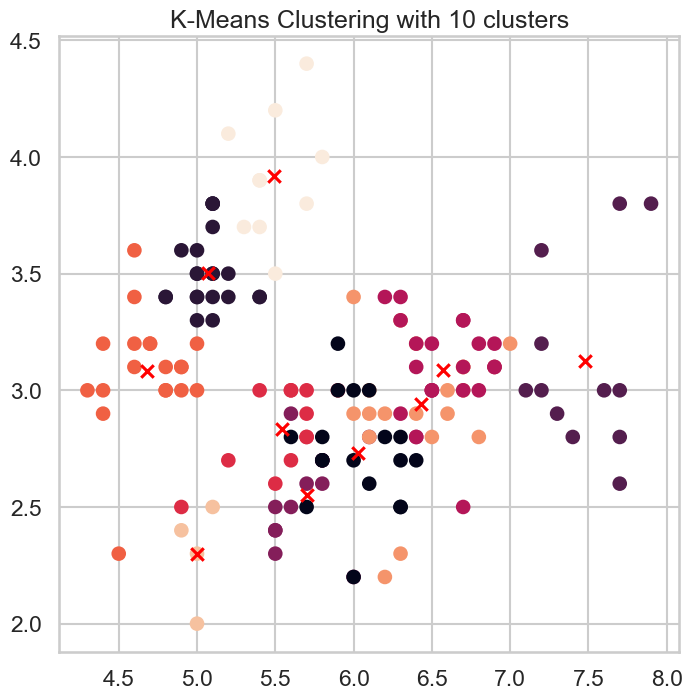

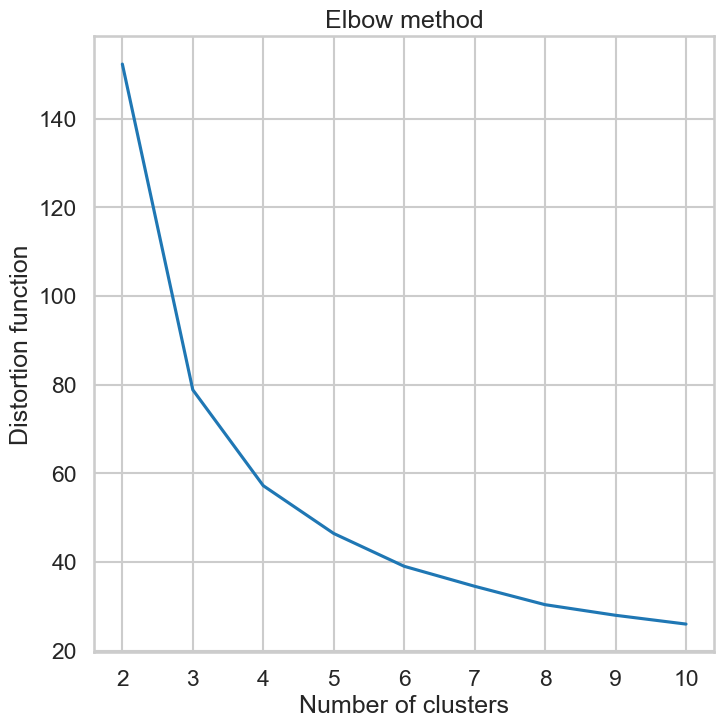

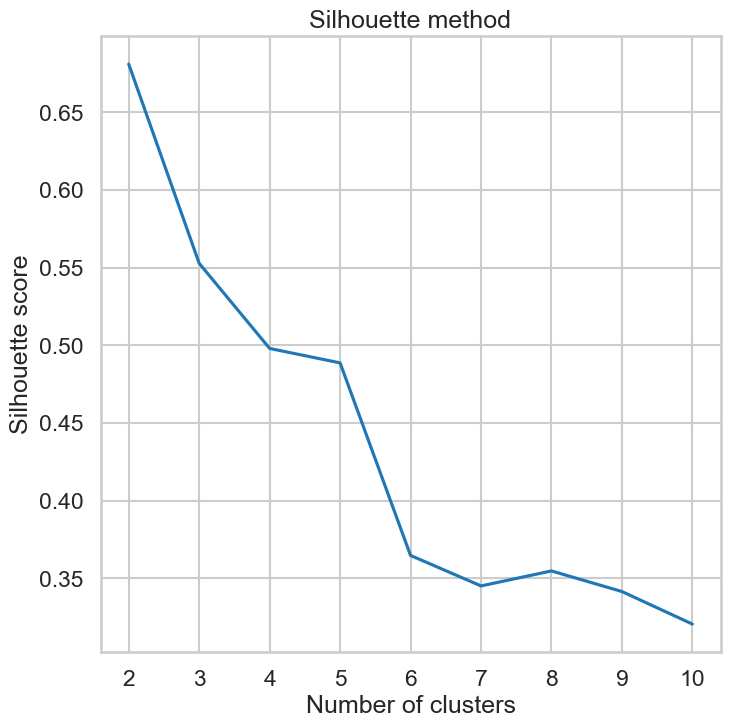

In [15]:
kmean_iris_data_silhouette_score = K_mean_method(iris_data.data)

### Hierarchal Clustering 

Optimum distance threshold = 2.0
Number of Clusters = 2
Score = 0.6867350732769777


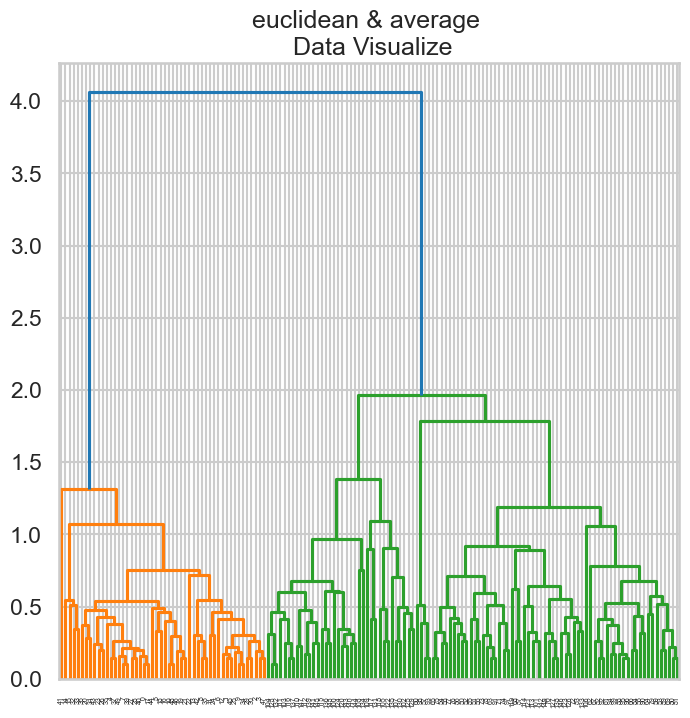

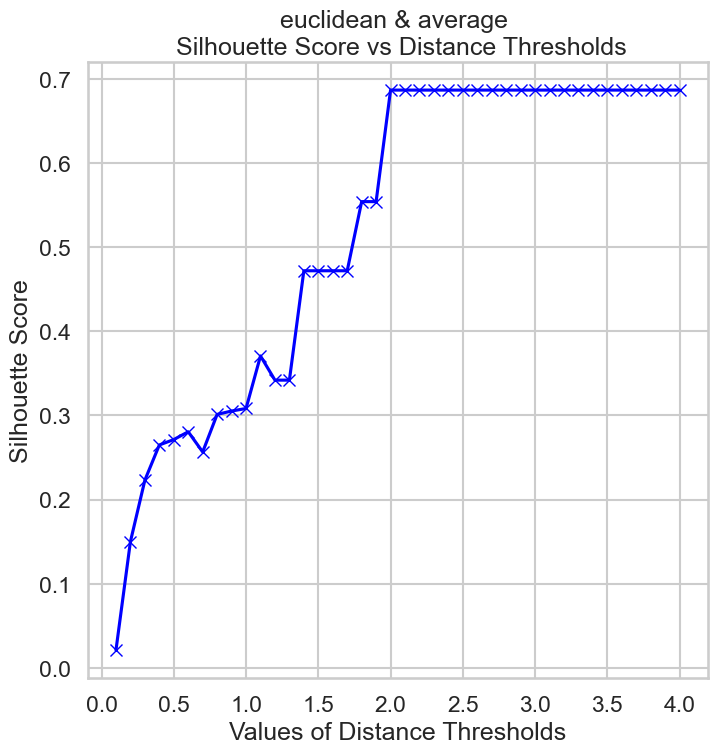

Optimum distance threshold = 0.9
Number of Clusters = 2
Score = 0.6867350732769777


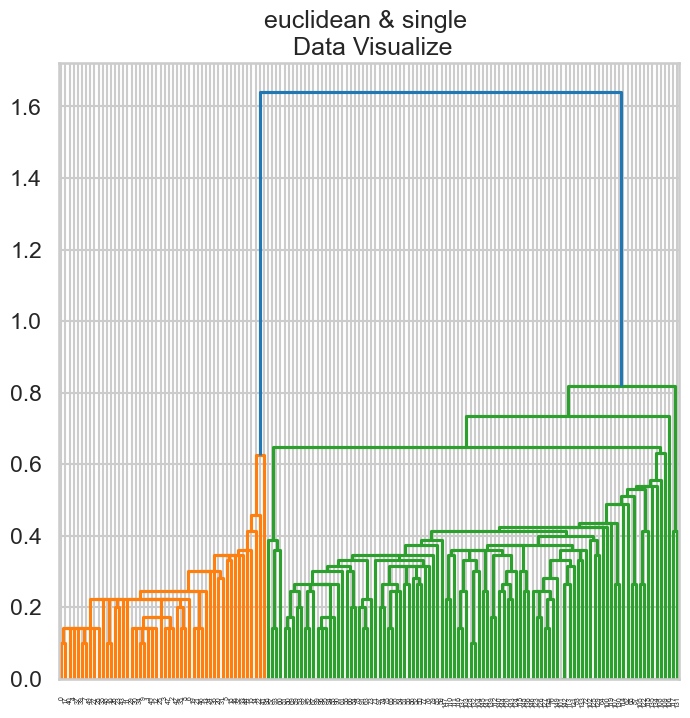

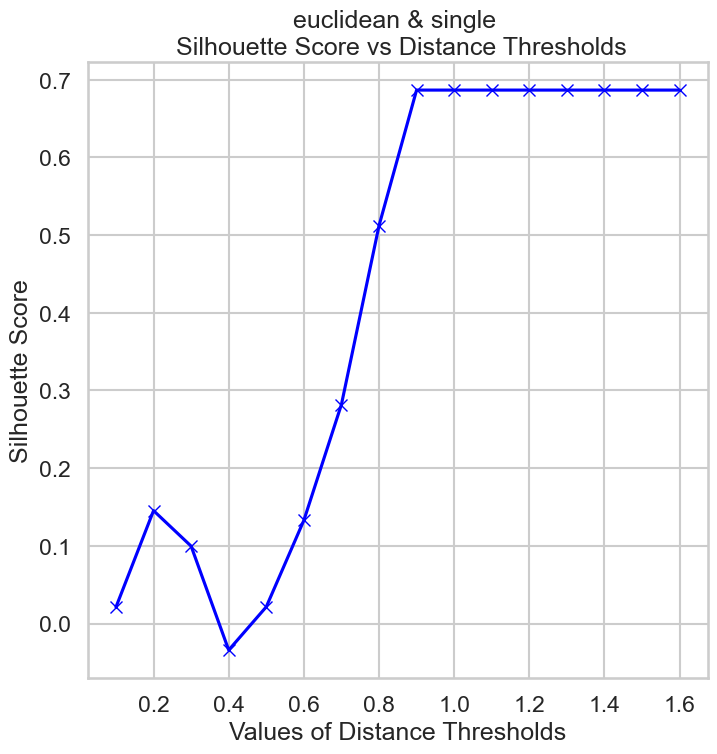

Optimum distance threshold = 3.5000000000000004
Number of Clusters = 2
Score = 0.6867350732769777


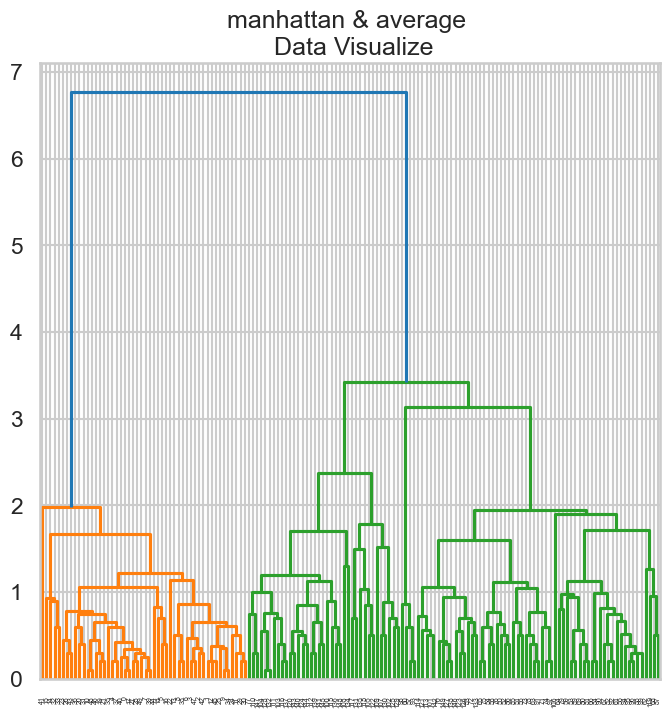

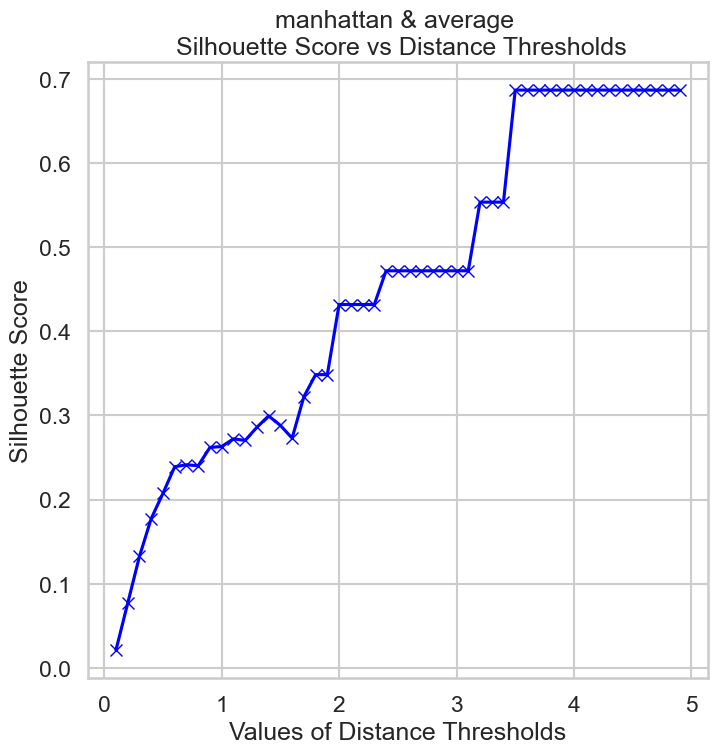

Optimum distance threshold = 1.2000000000000002
Number of Clusters = 2
Score = 0.6867350732769777


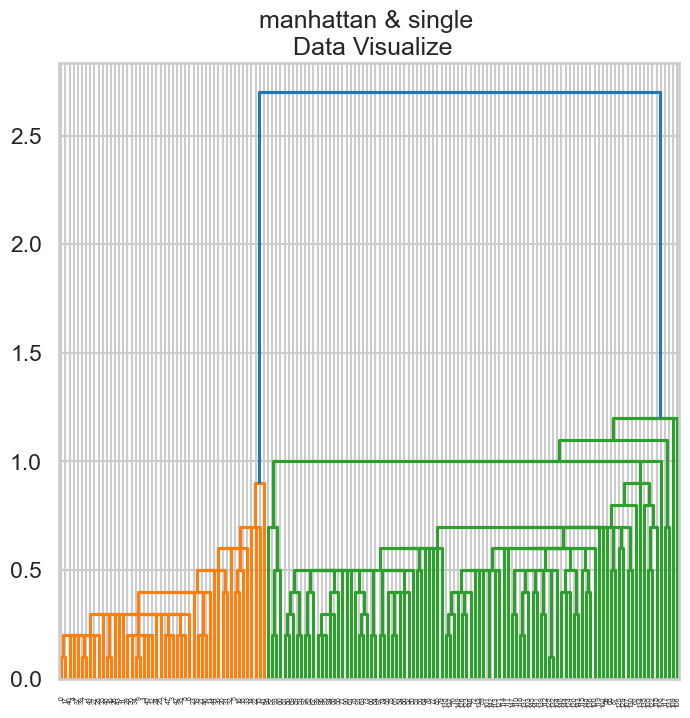

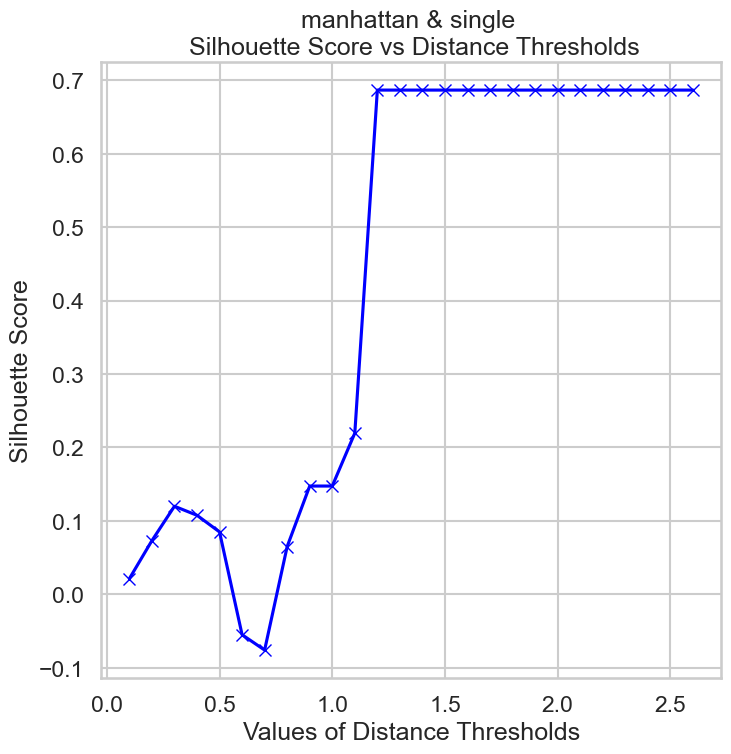

Optimum distance threshold = 0
Number of Clusters = 0
Score = -1


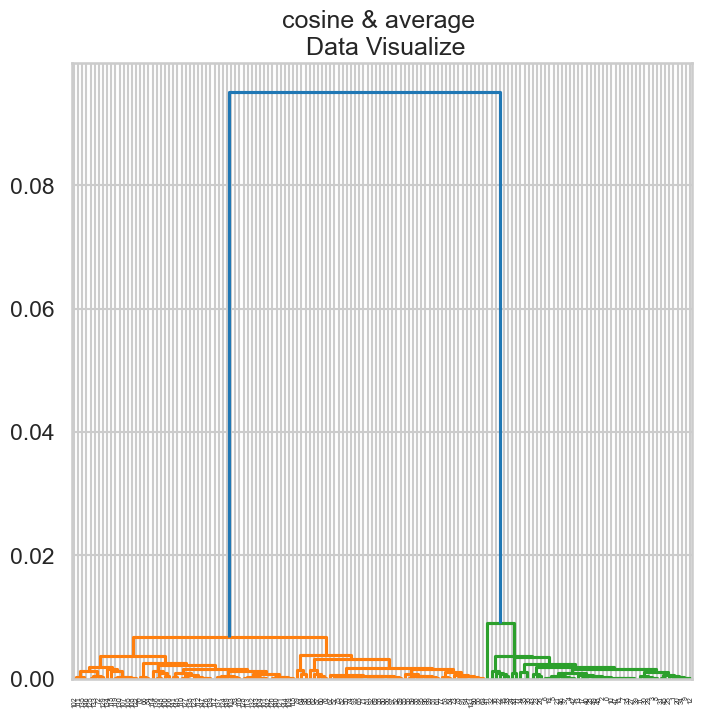

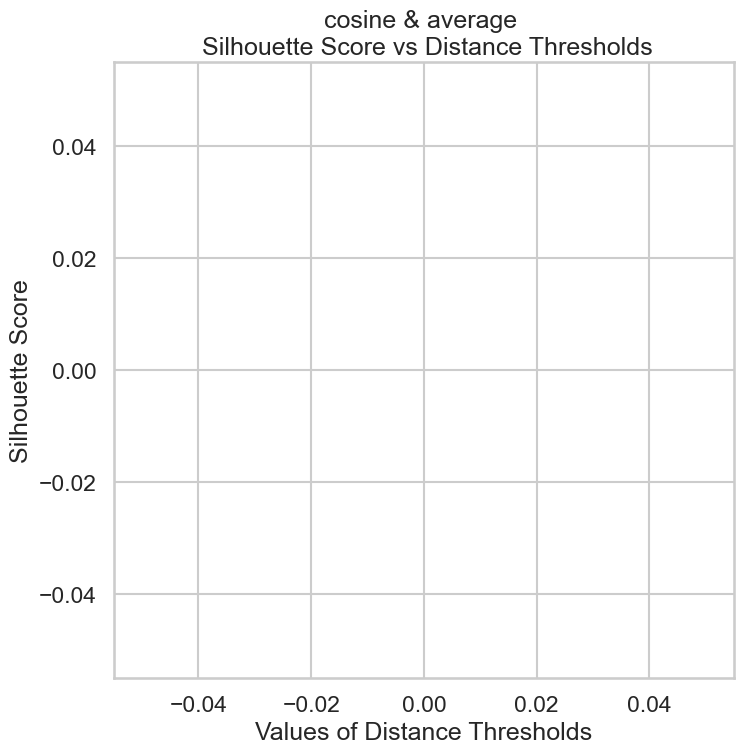

Optimum distance threshold = 0.0027999999999999995
Number of Clusters = 2
Score = 0.6867350732769777


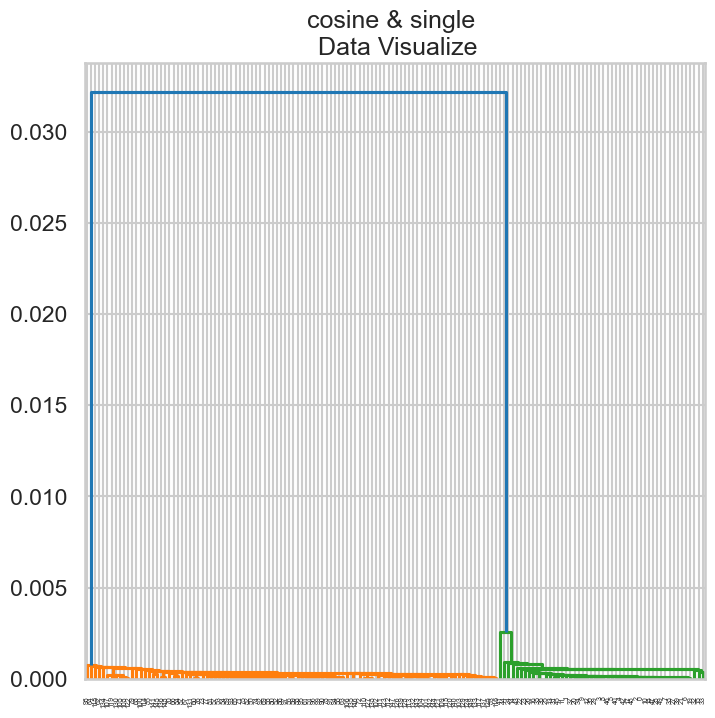

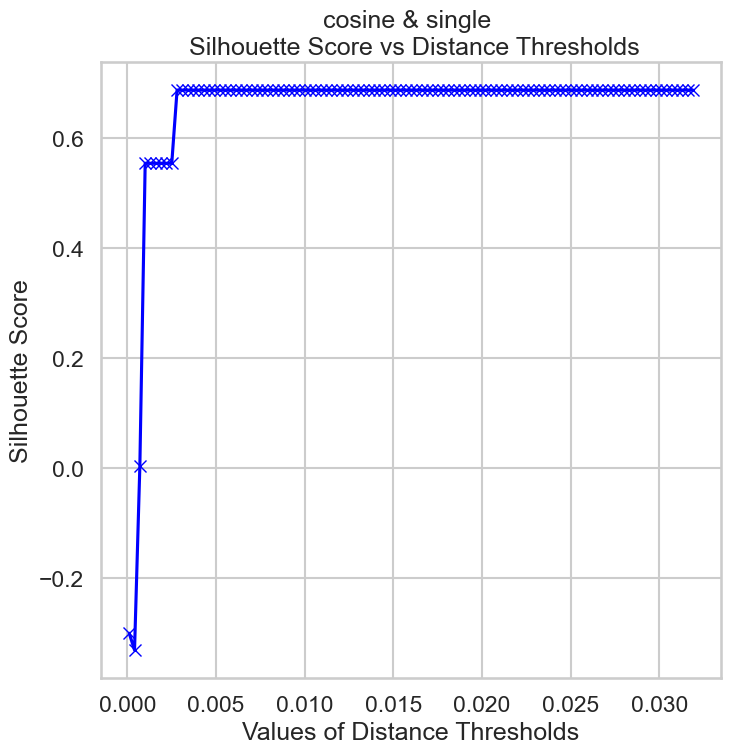

In [16]:
#euclidean & average
[hierarchial_iris_data_score1, hierarchial_iris_data_cluster1, hierarchial_iris_data_best_silhouette1] = hierarchial_method(iris_data.data, "euclidean", "average")

#euclidean & single
[hierarchial_iris_data_score2, hierarchial_iris_data_cluster2, hierarchial_iris_data_best_silhouette2] = hierarchial_method(iris_data.data, "euclidean", "single")

#manhattan & average
[hierarchial_iris_data_score3, hierarchial_iris_data_cluster3, hierarchial_iris_data_best_silhouette3] = hierarchial_method(iris_data.data, "manhattan", "average")

#manhattan & single
[hierarchial_iris_data_score4, hierarchial_iris_data_cluster4, hierarchial_iris_data_best_silhouette4] = hierarchial_method(iris_data.data, "manhattan", "single")

#cosine & average
[hierarchial_iris_data_score5, hierarchial_iris_data_cluster5, hierarchial_iris_data_best_silhouette5] = hierarchial_method(iris_data.data, "cosine", "average")

#cosine & single
[hierarchial_iris_data_score6, hierarchial_iris_data_cluster6, hierarchial_iris_data_best_silhouette6] = hierarchial_method(iris_data.data, "cosine", "single")

### DBScan

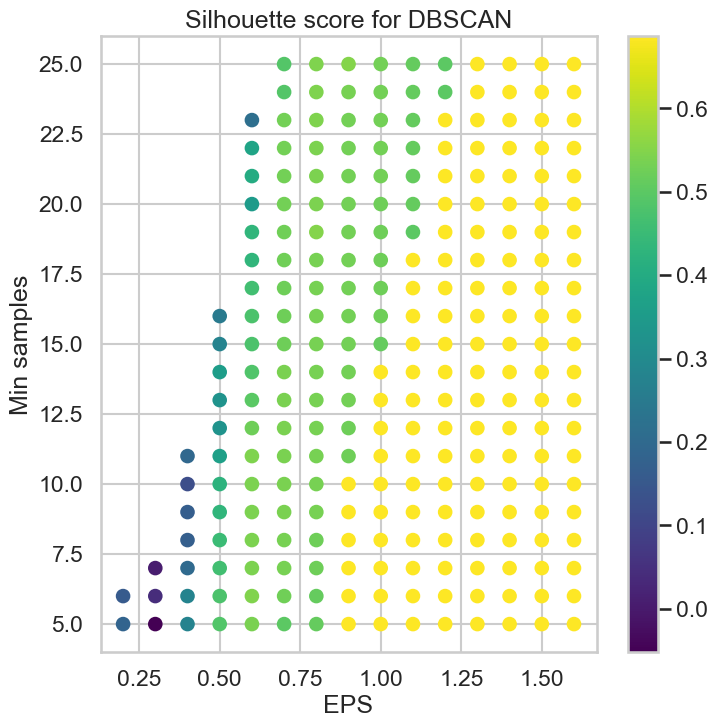

The best silhouette score is 0.687 with eps=0.9 and min_samples=5


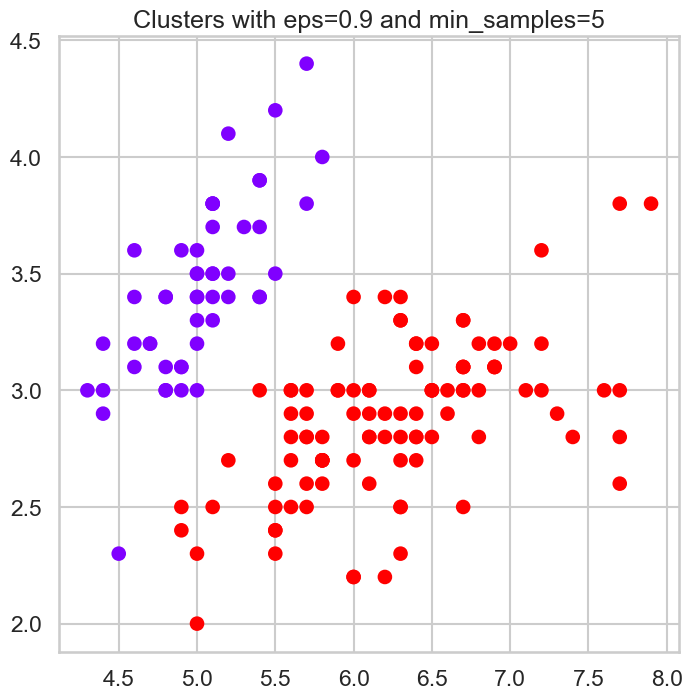

In [17]:
DBScan_method(iris_data.data)

### Gaussian Mixture

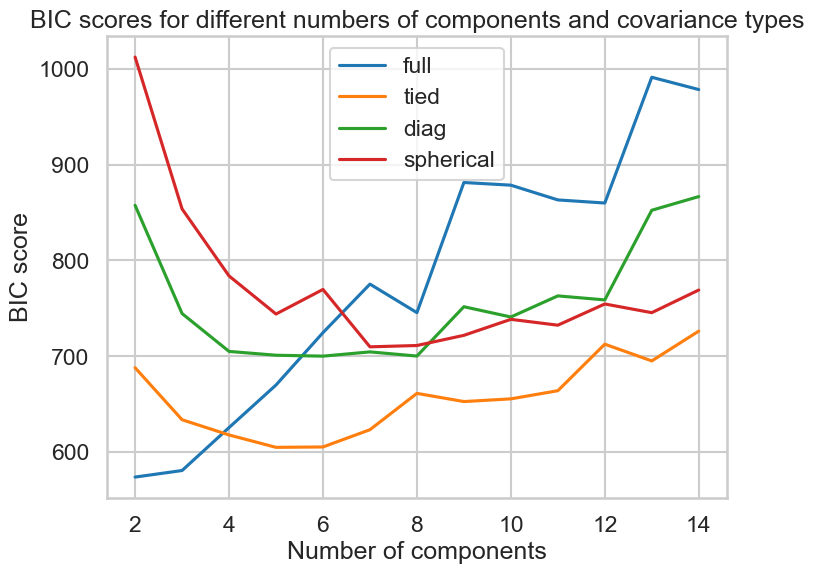

In [19]:
gaussian_method(iris_data.data)

## Normalized iris data set 

In [20]:
normalized_matrix = StandardScaler().fit_transform(iris_data.data)

### Kmeans

The best value of K based on elbow method is 2
The best value of K based on silhouette score is 2
The silhouette score for best value of k is 0.5817500491982808


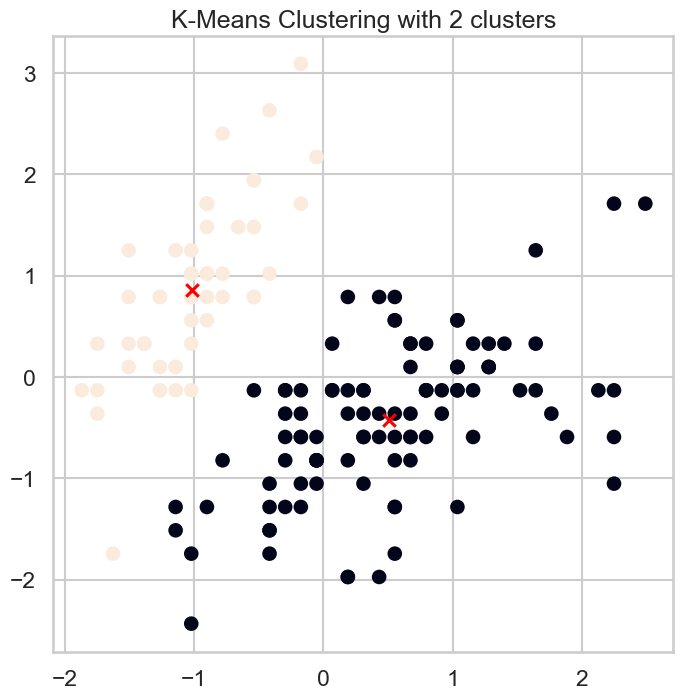

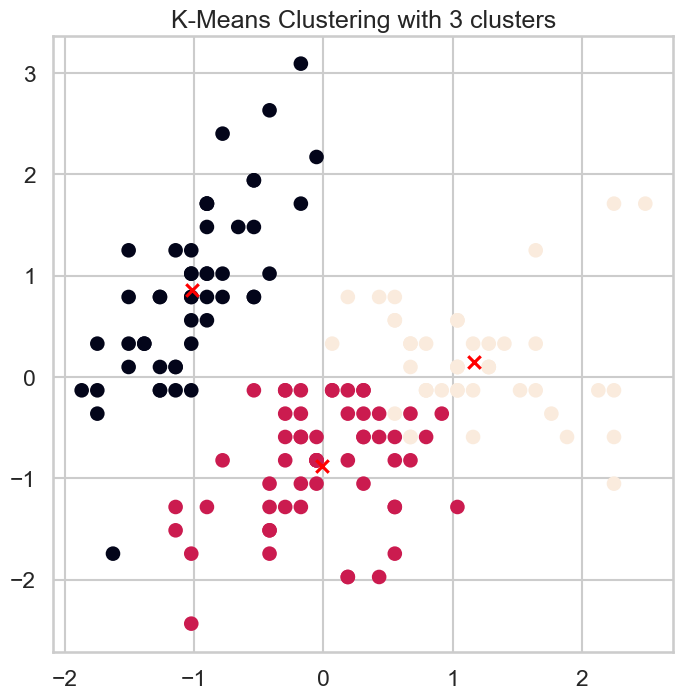

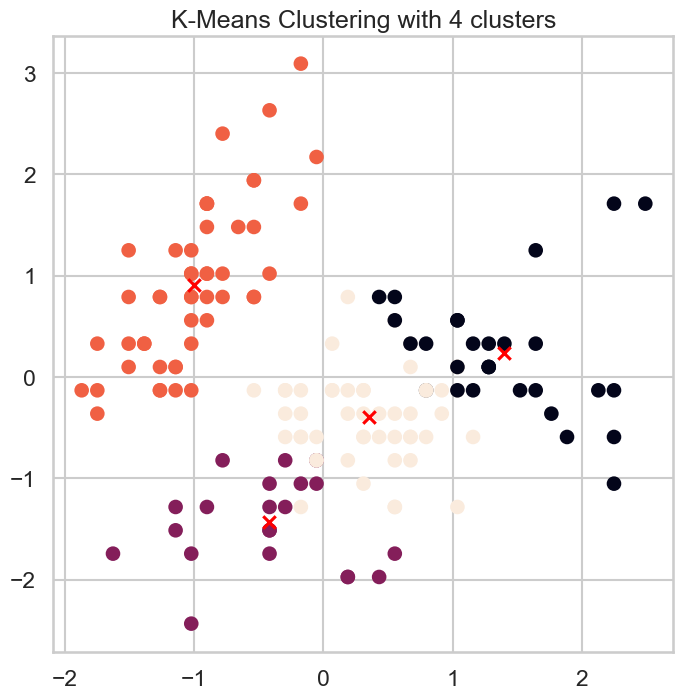

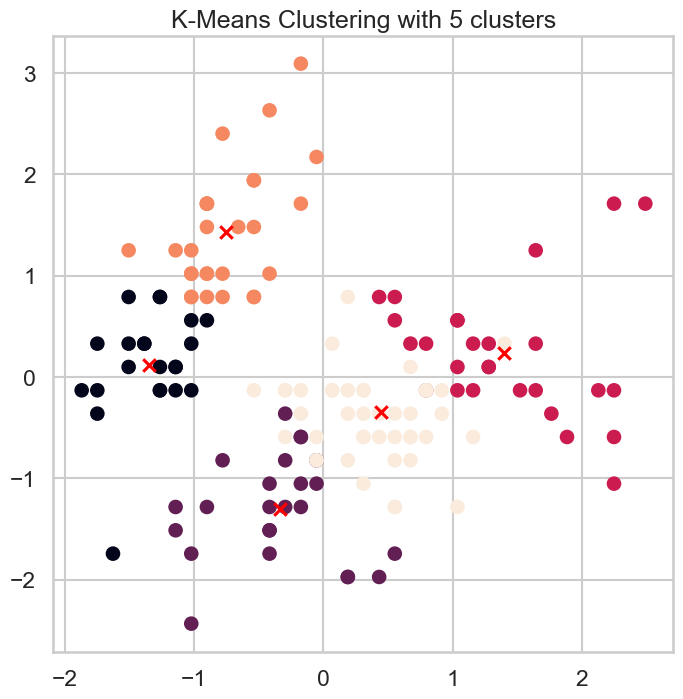

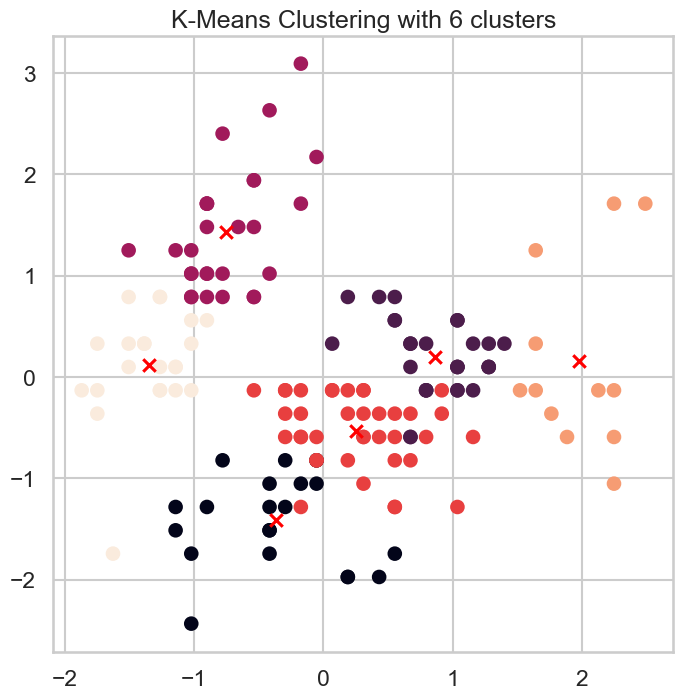

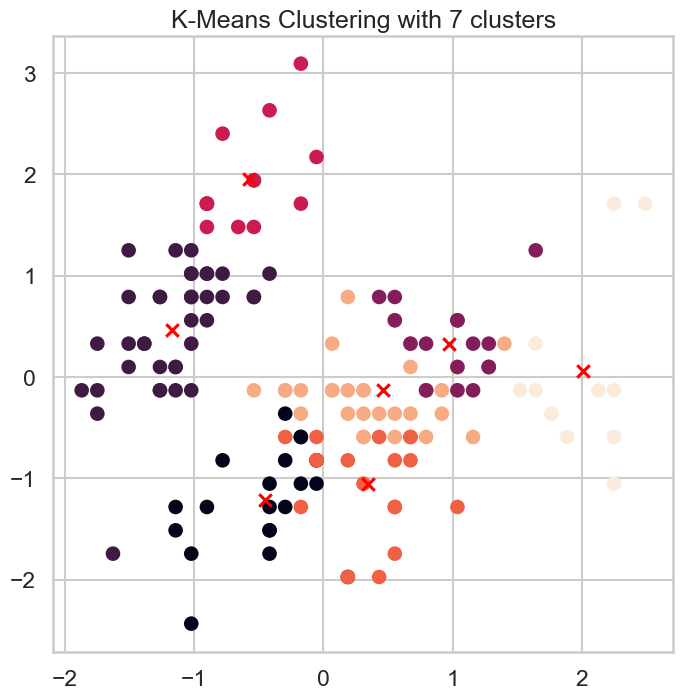

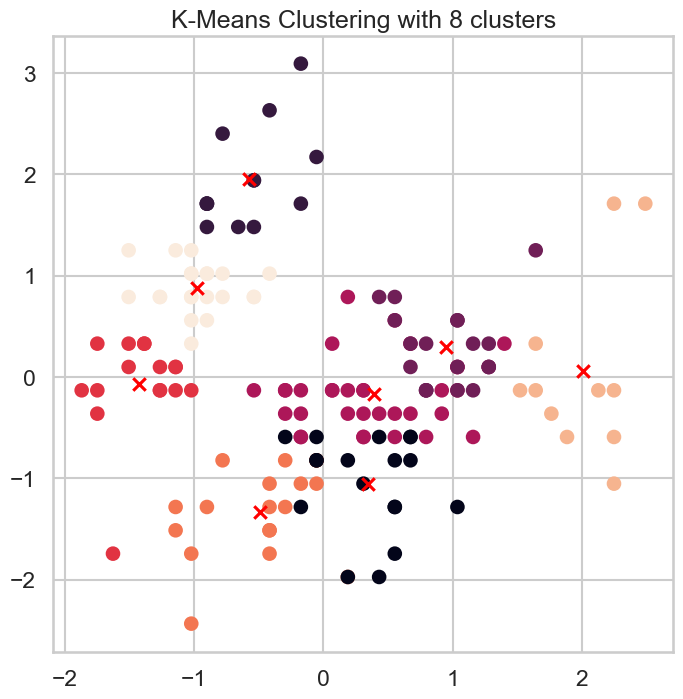

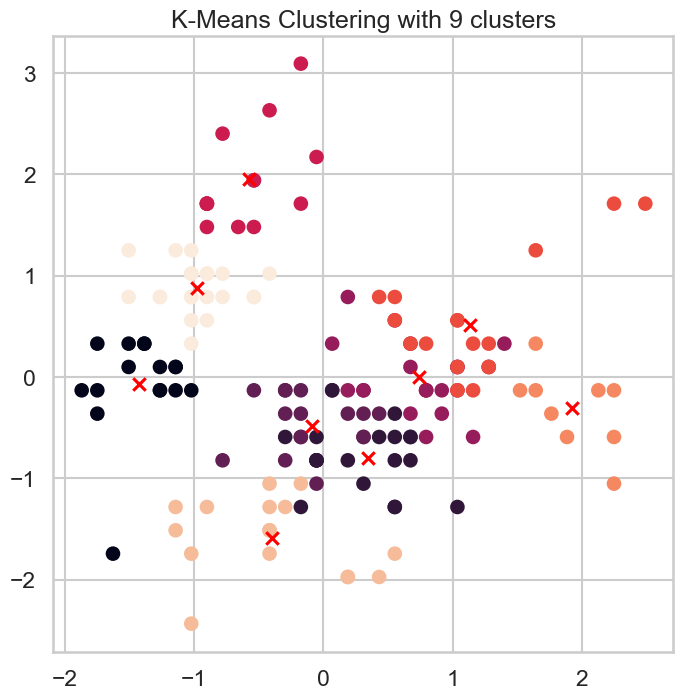

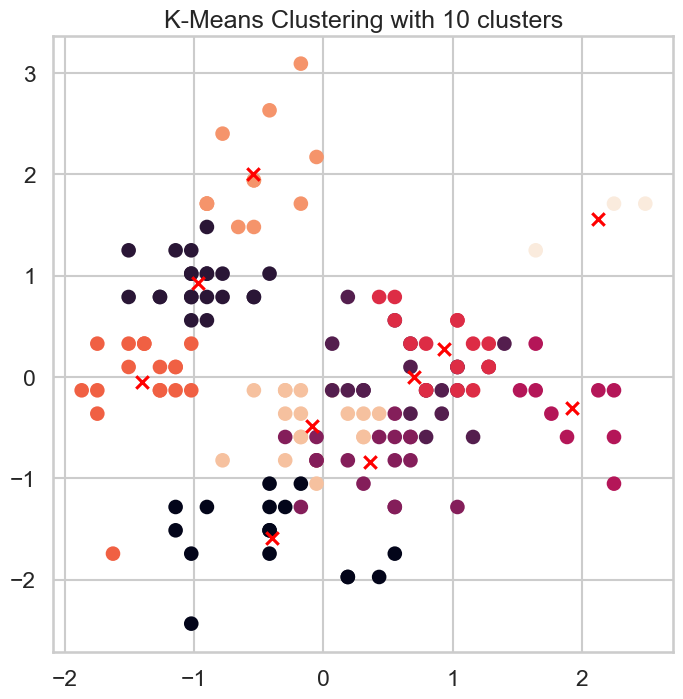

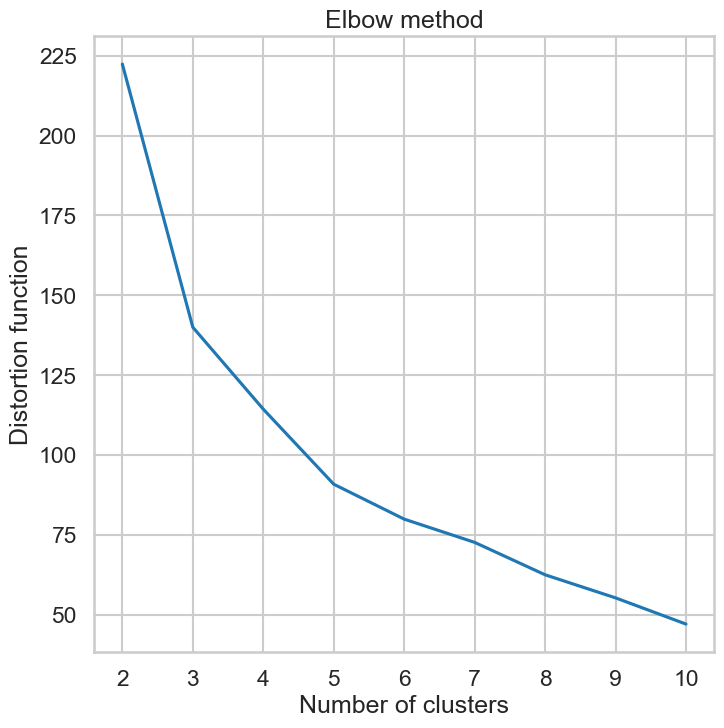

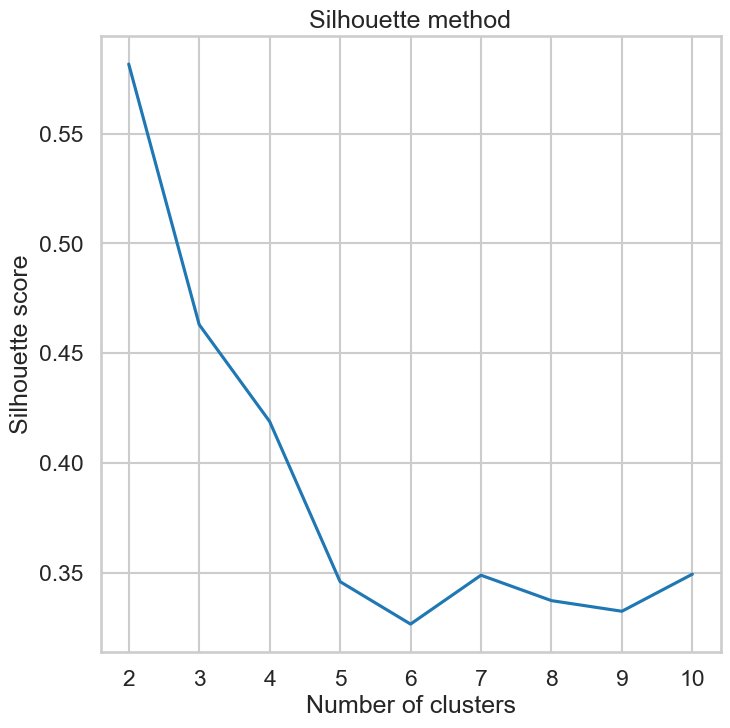

In [21]:
kmean_normalized_matrix_silhouette_score = K_mean_method(normalized_matrix)

### Hierarchal Clustering 

Optimum distance threshold = 3.1
Number of Clusters = 2
Score = 0.5817500491982808


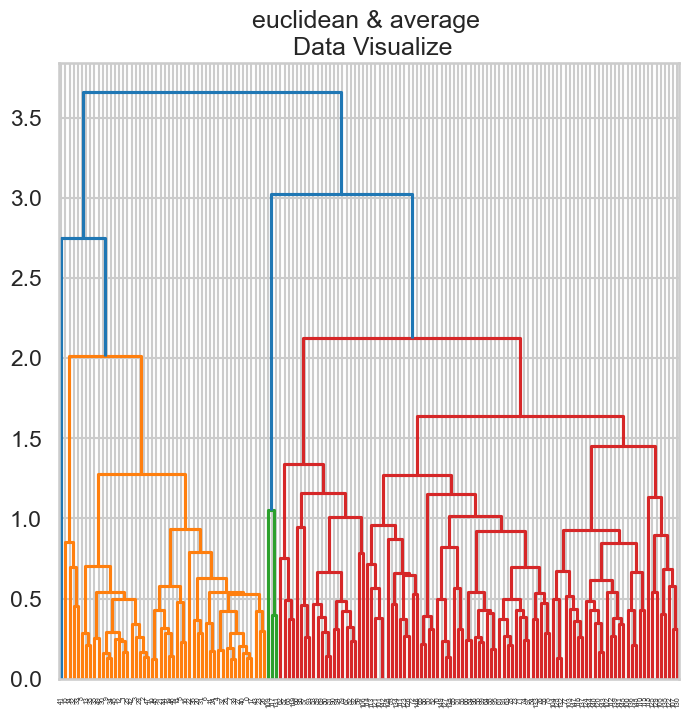

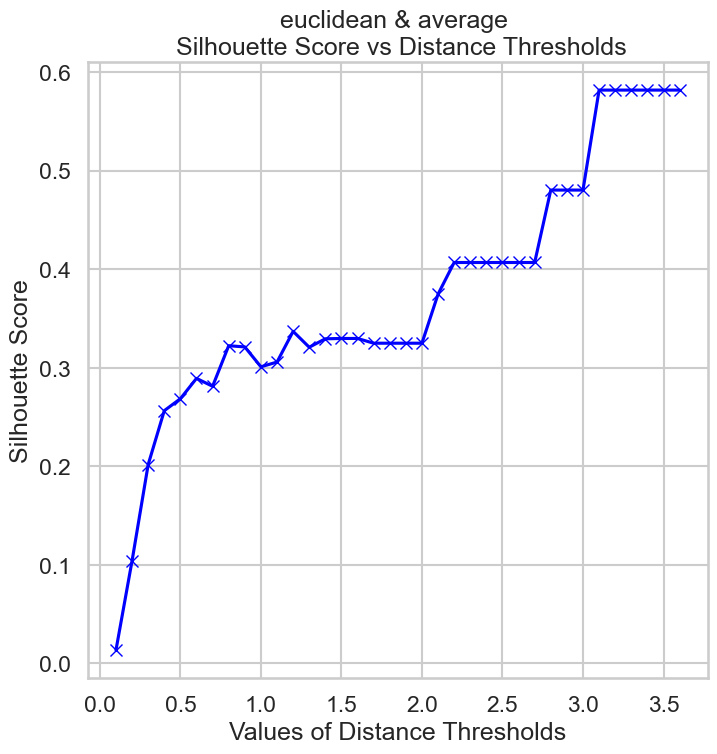

Optimum distance threshold = 1.4000000000000001
Number of Clusters = 2
Score = 0.5817500491982808


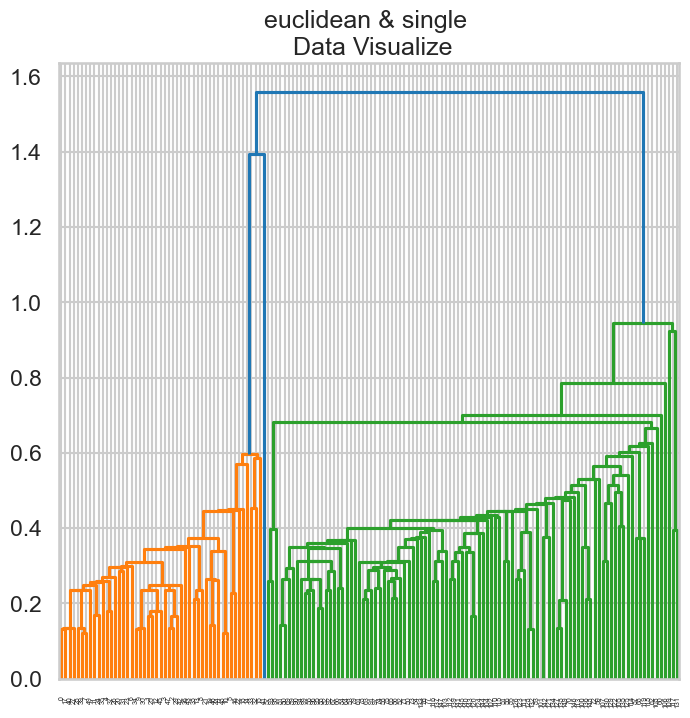

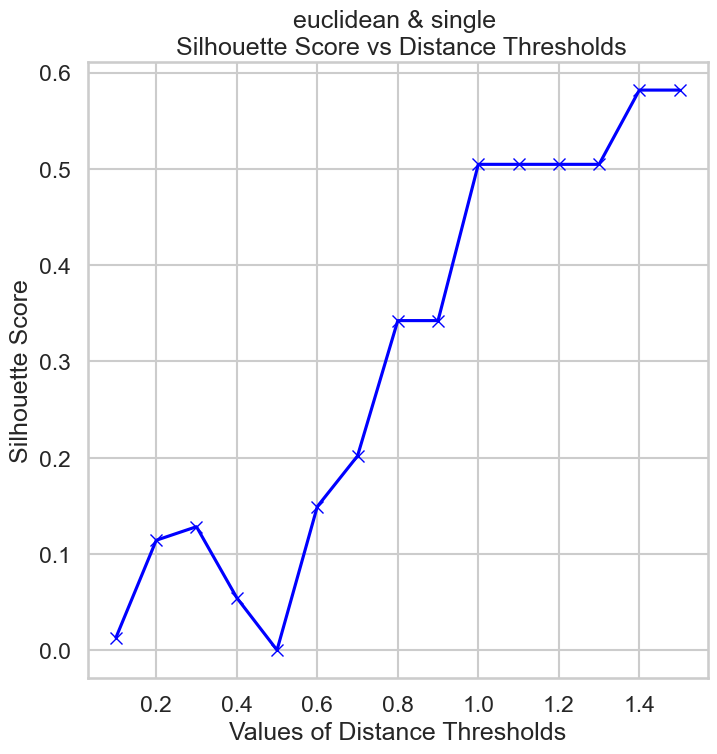

Optimum distance threshold = 3.9000000000000004
Number of Clusters = 2
Score = 0.5817500491982808


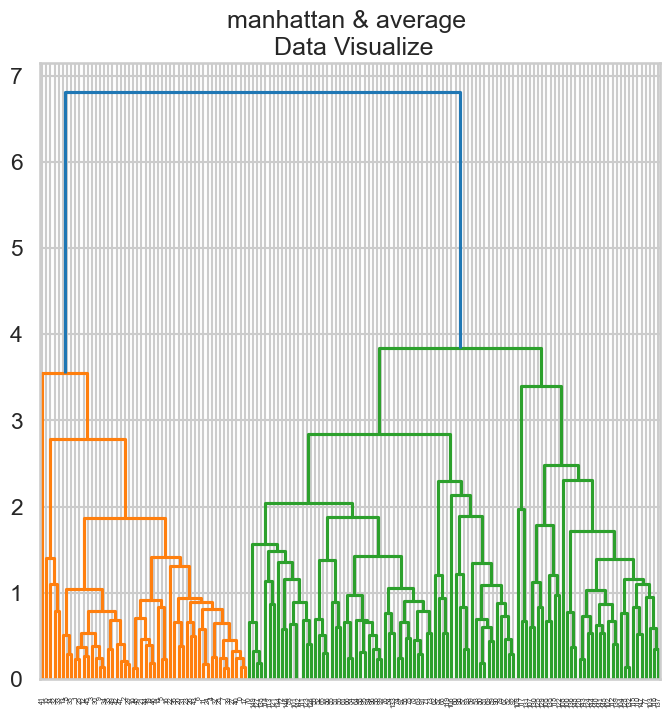

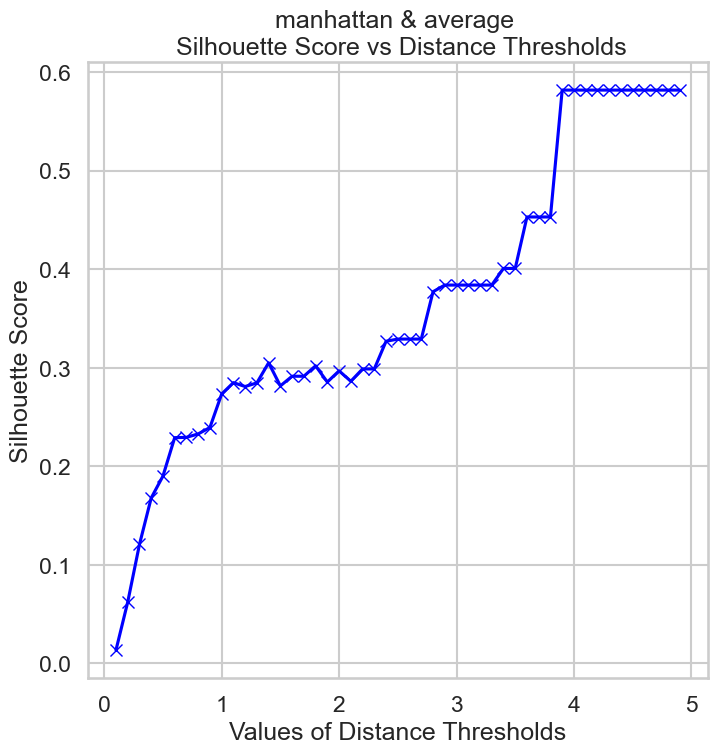

Optimum distance threshold = 1.9000000000000001
Number of Clusters = 2
Score = 0.5817500491982808


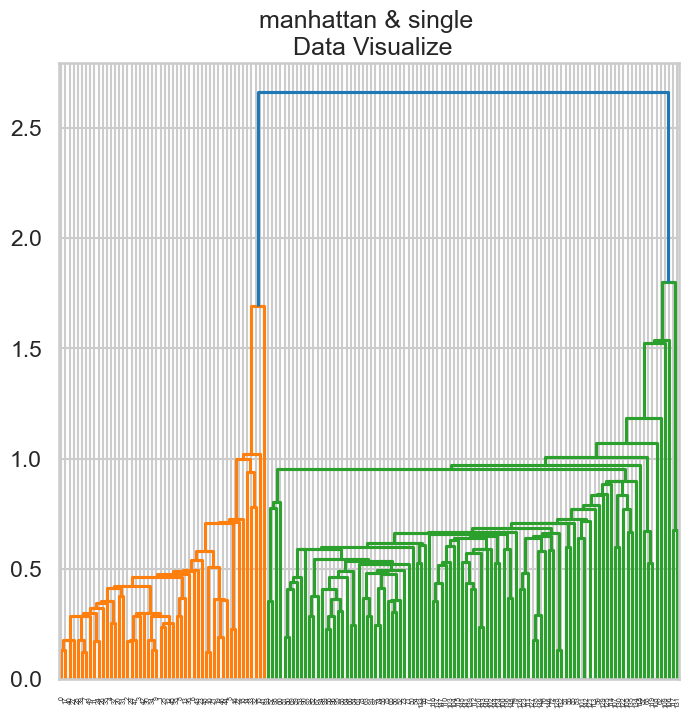

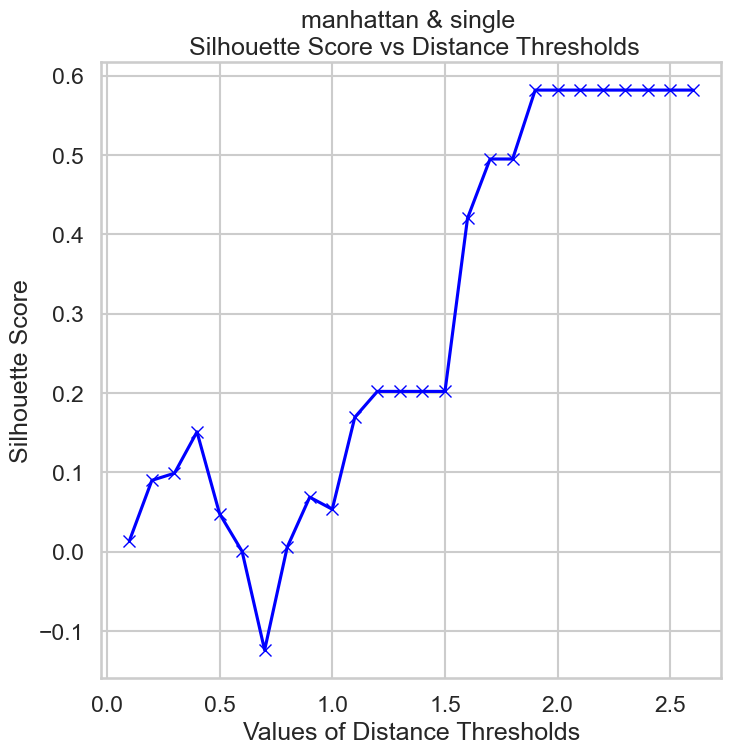

Optimum distance threshold = 1.0
Number of Clusters = 2
Score = 0.5770346019475988


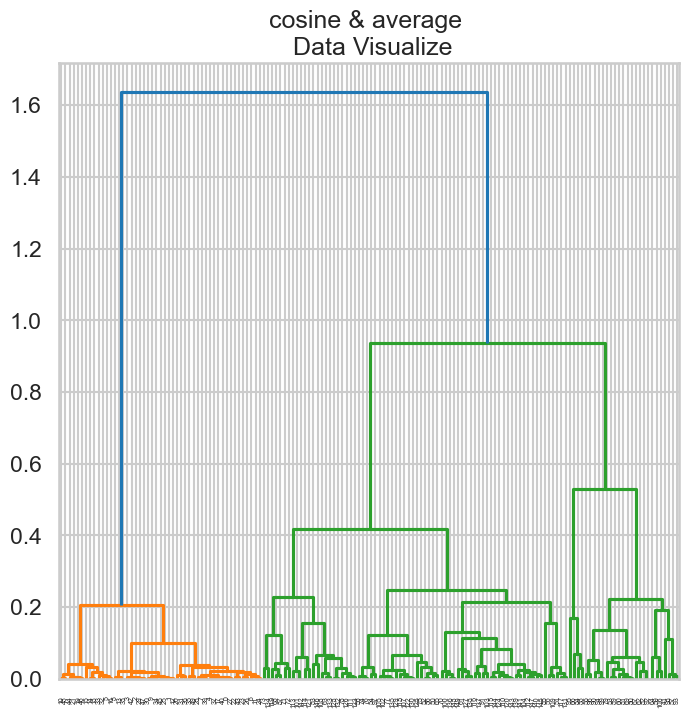

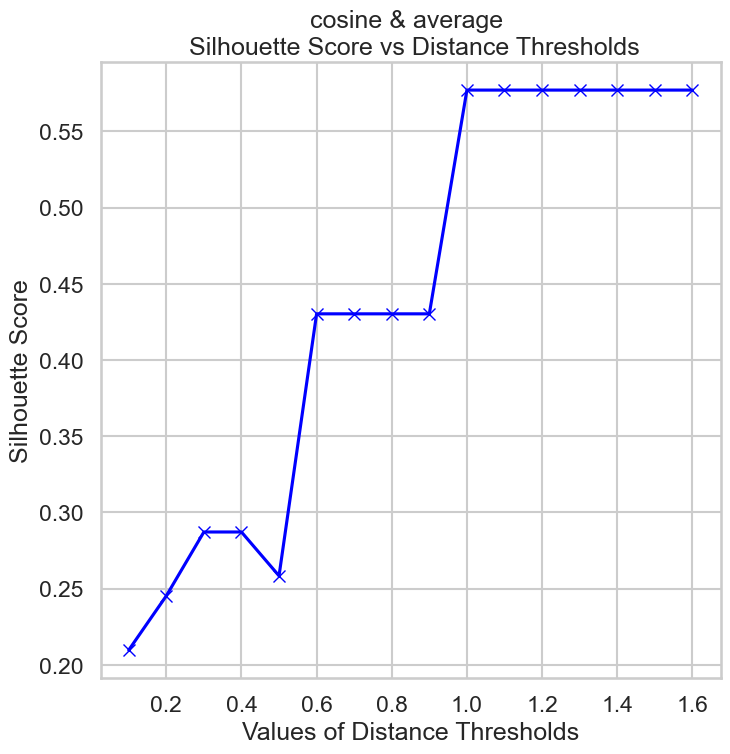

Optimum distance threshold = 0.0073
Number of Clusters = 79
Score = 0.0956440585647344


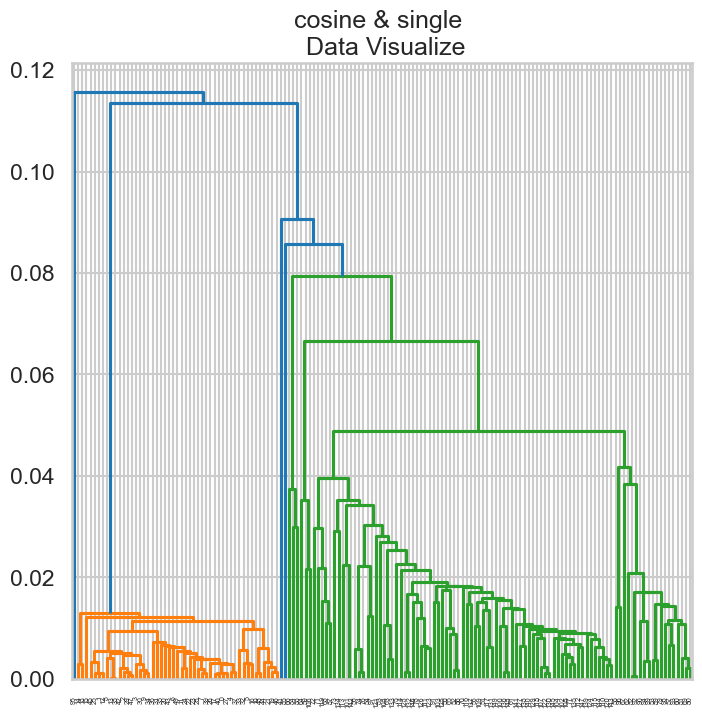

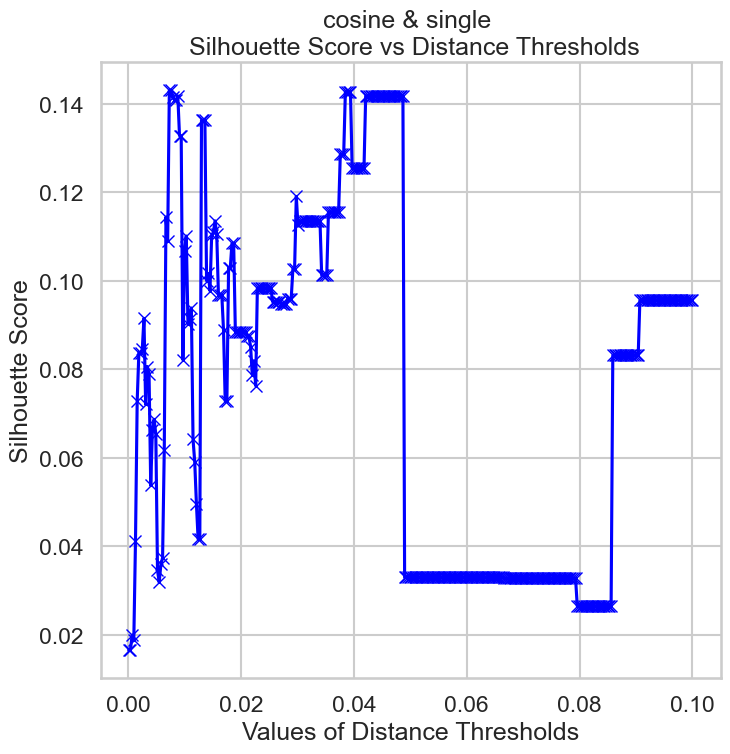

In [22]:
#euclidean & average
[hierarchial_normalized_matrix_score1, hierarchial_normalized_matrix_cluster1, hierarchial_normalized_matrix_best_silhouette1] = hierarchial_method(normalized_matrix, "euclidean", "average")

#euclidean & single
[hierarchial_normalized_matrix_score2, hierarchial_normalized_matrix_cluster2, hierarchial_normalized_matrix_best_silhouette2] = hierarchial_method(normalized_matrix, "euclidean", "single")

#manhattan & average
[hierarchial_normalized_matrix_score3, hierarchial_normalized_matrix_cluster3, hierarchial_normalized_matrix_best_silhouette3] = hierarchial_method(normalized_matrix, "manhattan", "average")

#manhattan & single
[hierarchial_normalized_matrix_score4, hierarchial_normalized_matrix_cluster4, hierarchial_normalized_matrix_best_silhouette4] = hierarchial_method(normalized_matrix, "manhattan", "single")

#cosine & average
[hierarchial_normalized_matrix_score5, hierarchial_normalized_matrix_cluster5, hierarchial_normalized_matrix_best_silhouette5] = hierarchial_method(normalized_matrix, "cosine", "average")

#cosine & single
[hierarchial_normalized_matrix_score6, hierarchial_normalized_matrix_cluster6, hierarchial_normalized_matrix_best_silhouette6] = hierarchial_method(normalized_matrix, "cosine", "single")

### DBScan

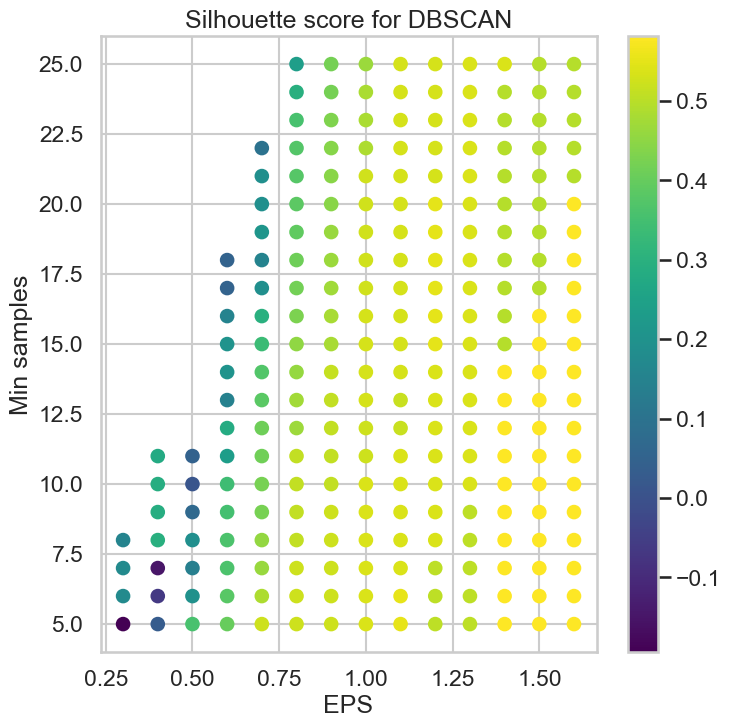

The best silhouette score is 0.582 with eps=1.4 and min_samples=5


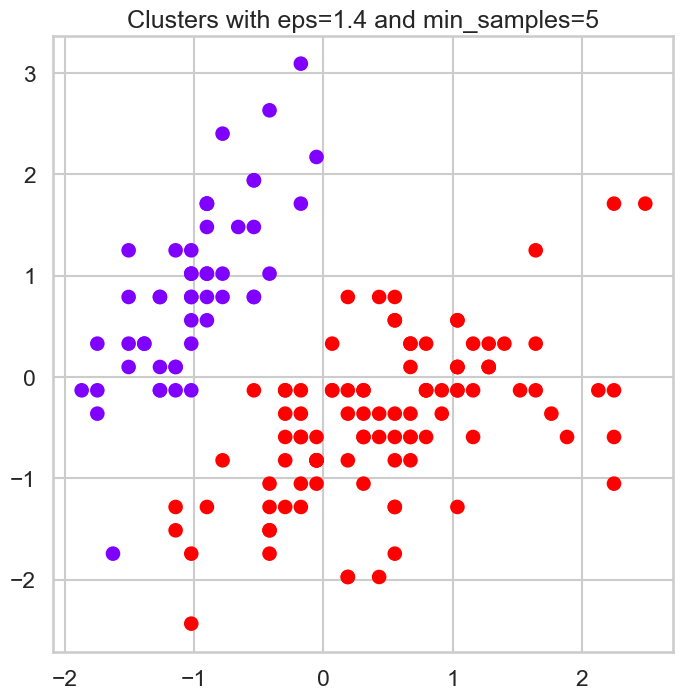

In [23]:
DBScan_method(normalized_matrix)

### Gaussian Mixture

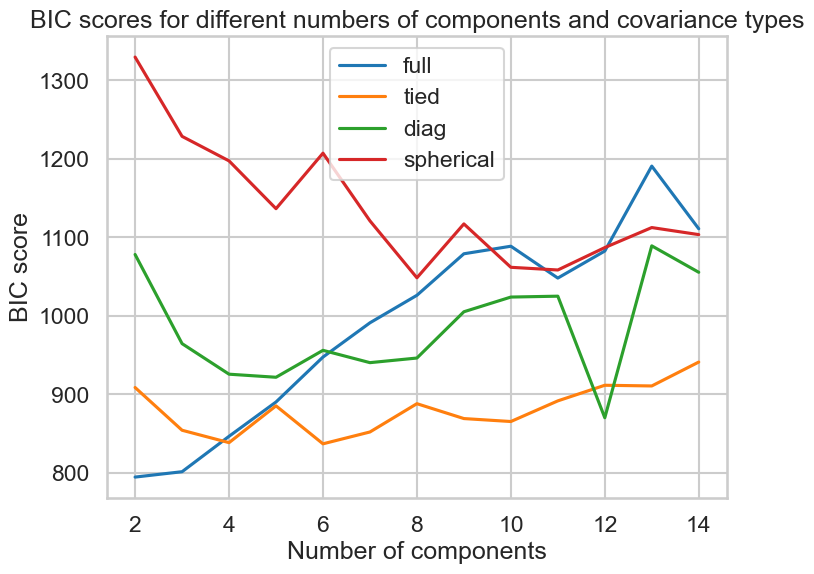

In [24]:
gaussian_method(normalized_matrix)

## Customer dataset
Repeat all the above on the customer data set 

In [25]:
df = pd.read_csv("E://University/Semester 10/Machine Learning (NETW1013)/Assignments/Assignment 1/Customer data.csv", index_col=0)

# Normalize the dataframe
df = StandardScaler().fit_transform(df)

### Kmeans

The best value of K based on elbow method is 2
The best value of K based on silhouette score is 10
The silhouette score for best value of k is 0.30951650206789116


0.30951650206789116

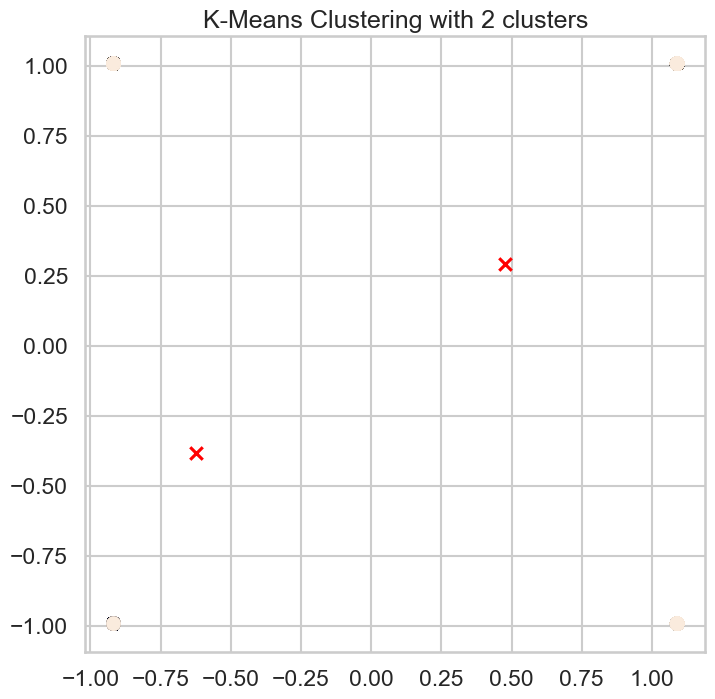

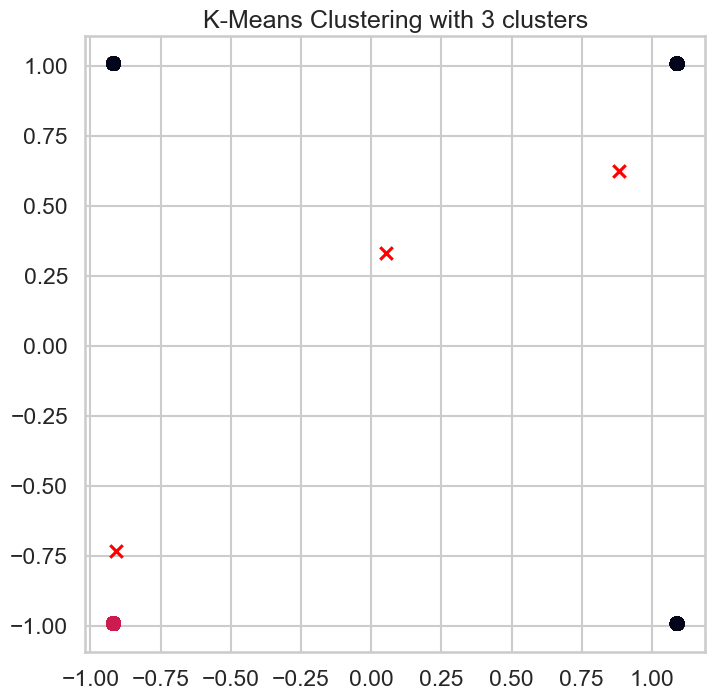

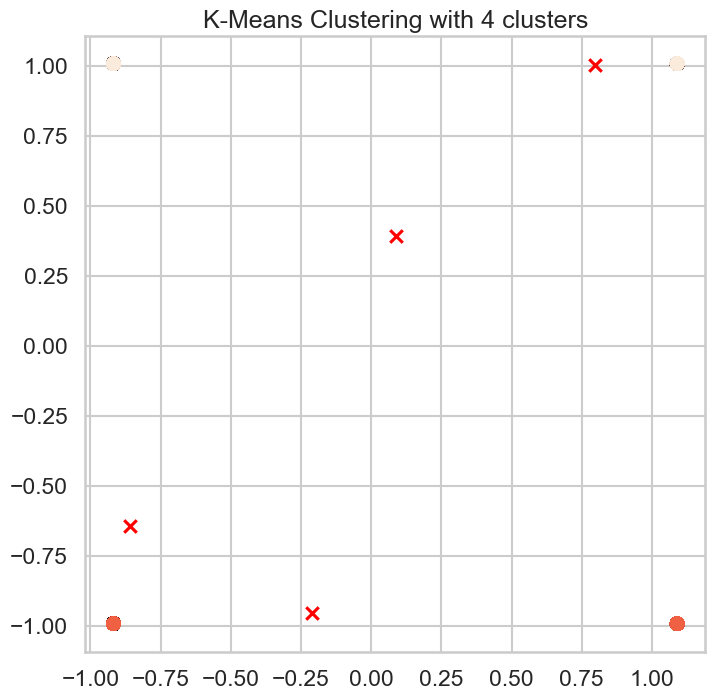

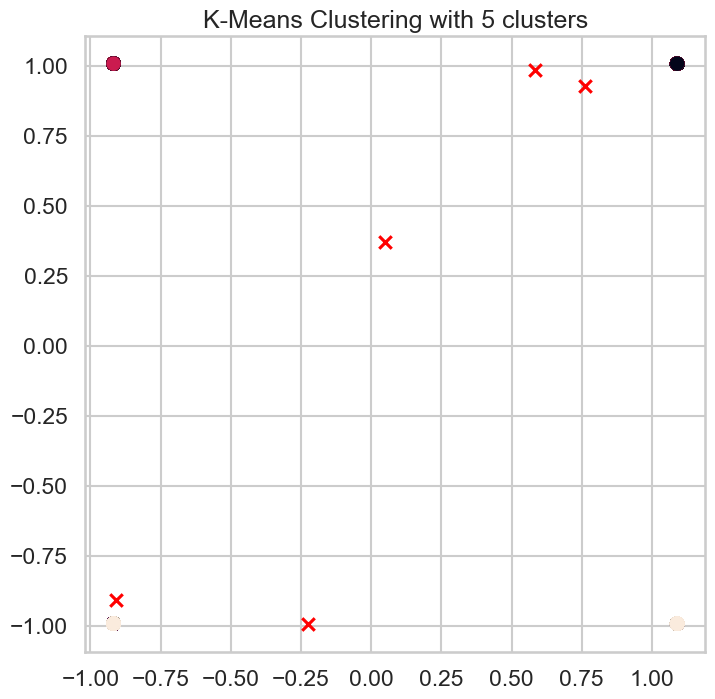

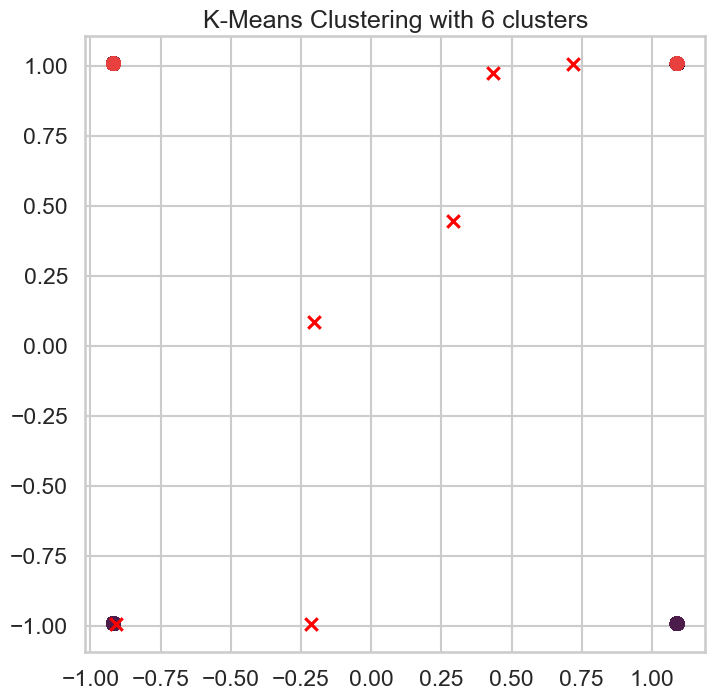

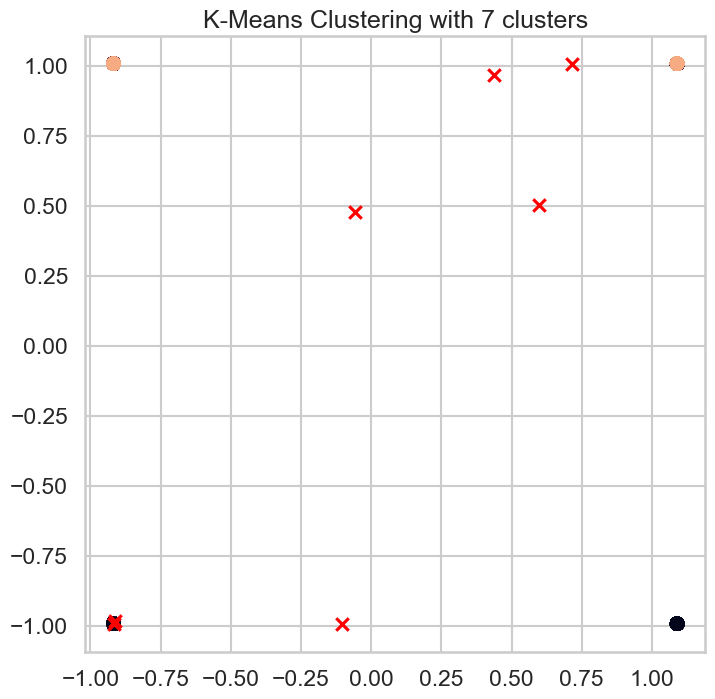

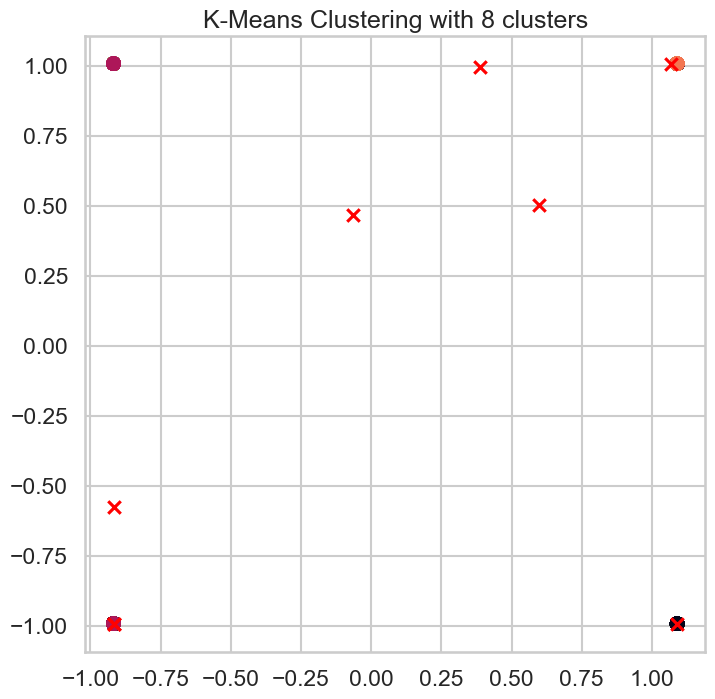

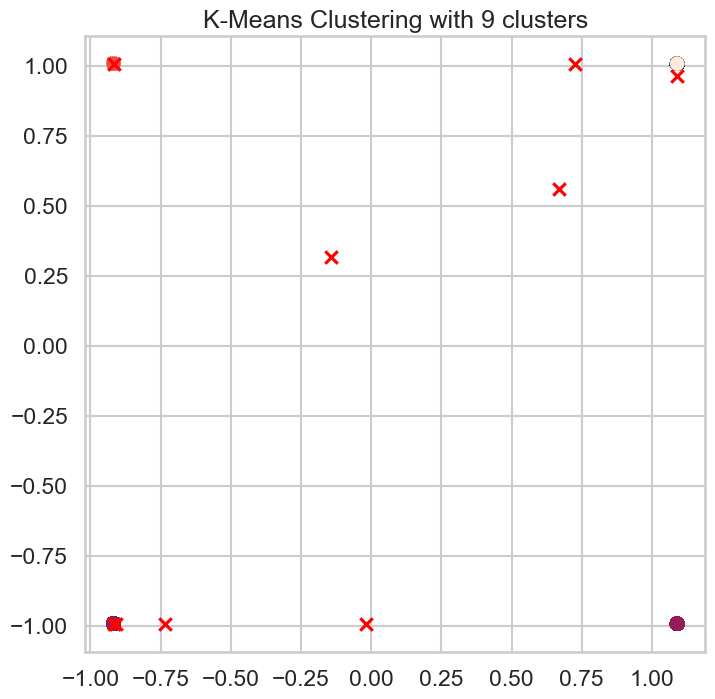

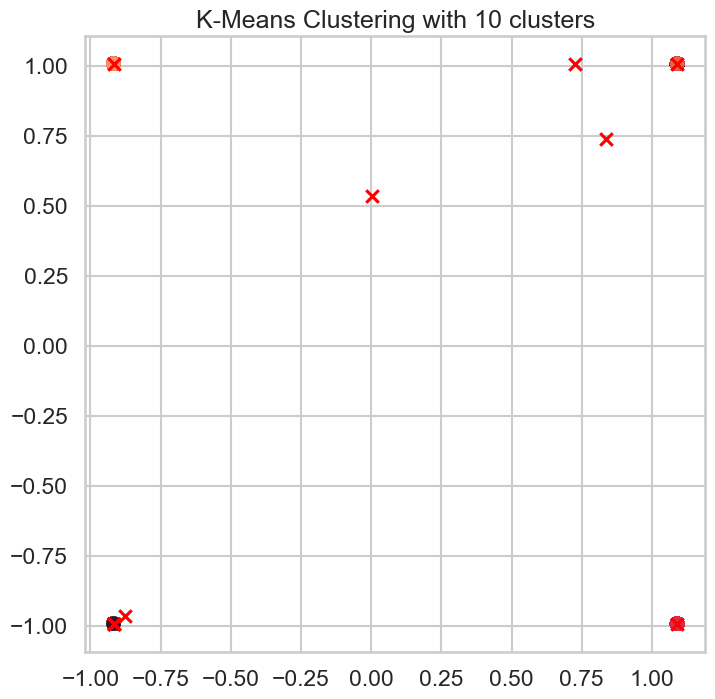

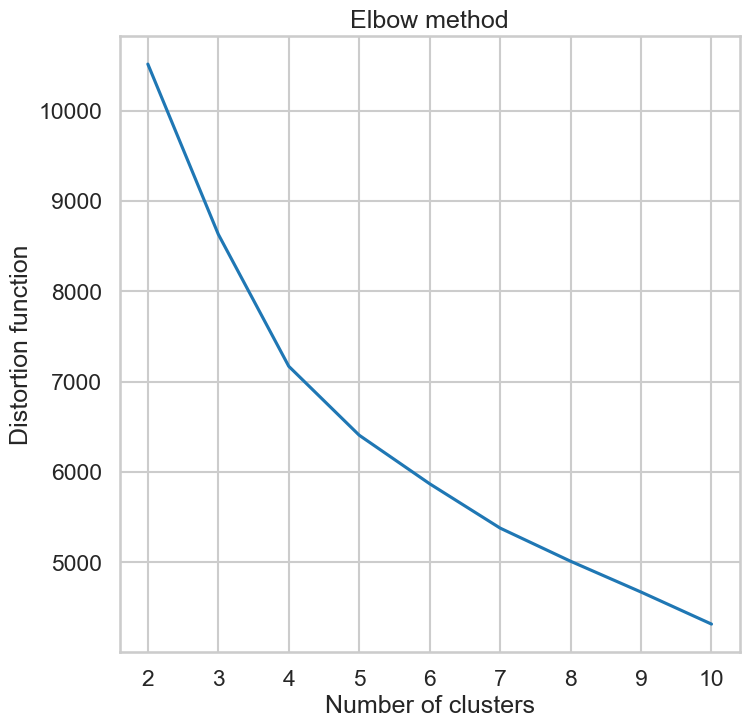

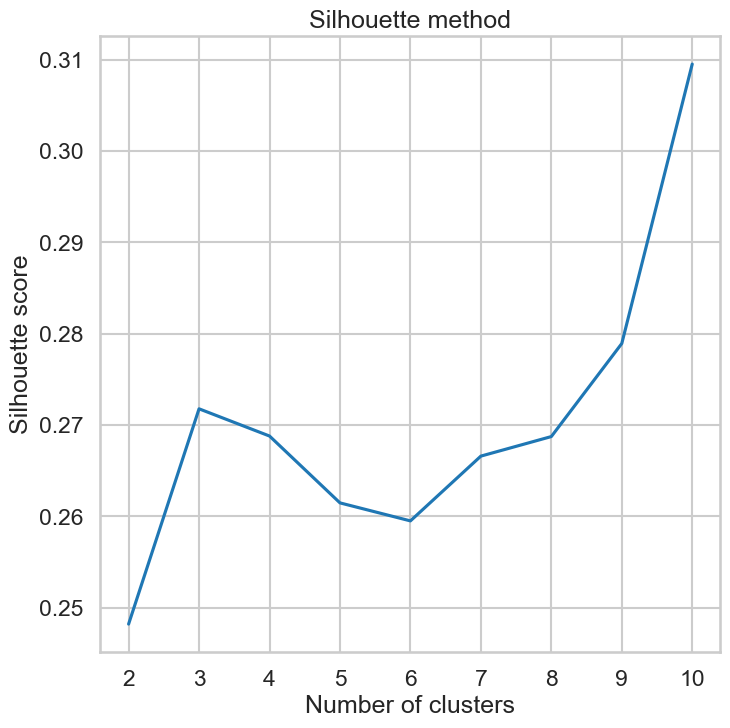

In [26]:
K_mean_method(df)

### Hierarchal Clustering 

Optimum distance threshold = 1.4000000000000001
Number of Clusters = 121
Score = 0.3969701495528368


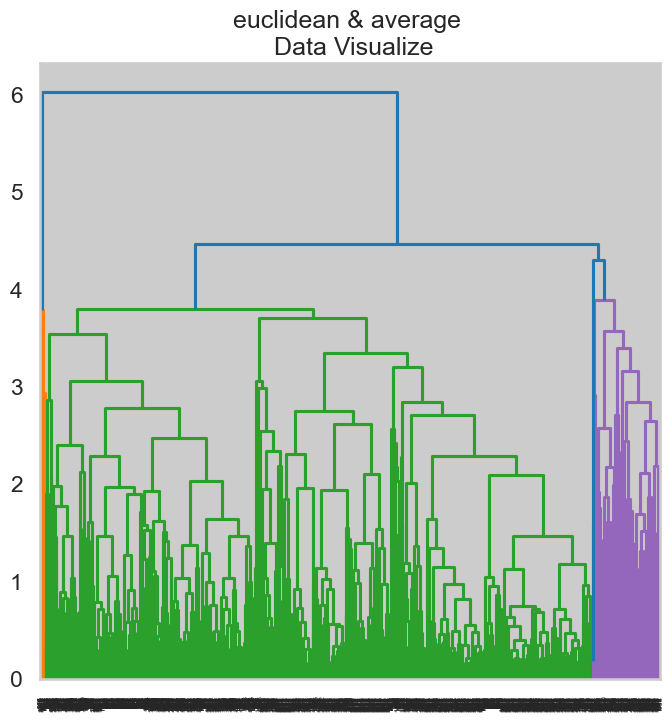

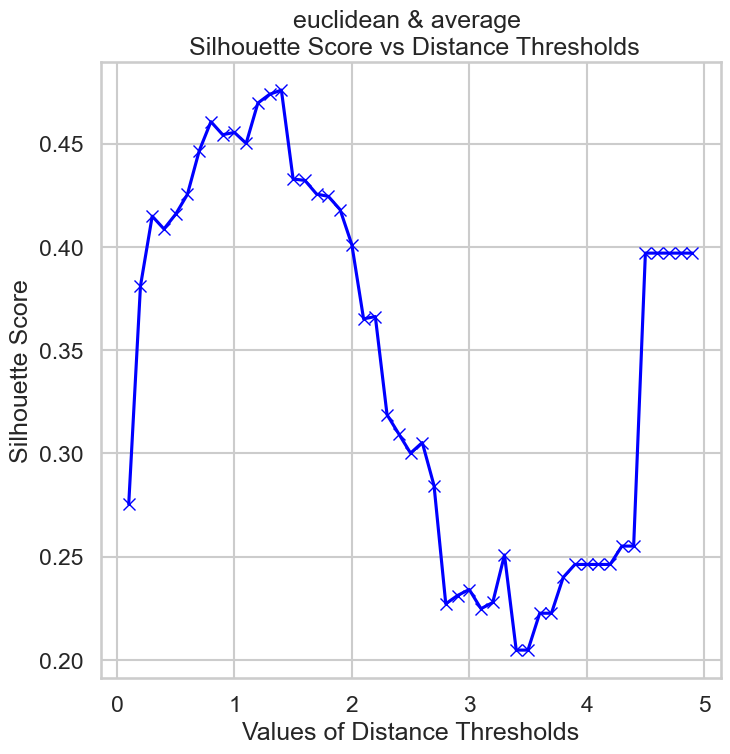

Optimum distance threshold = 0.9
Number of Clusters = 122
Score = 0.34916658225914216


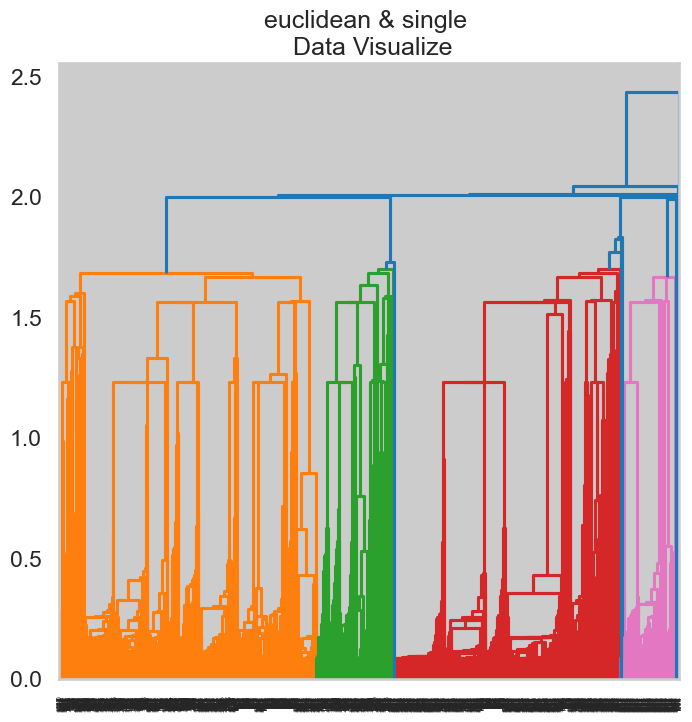

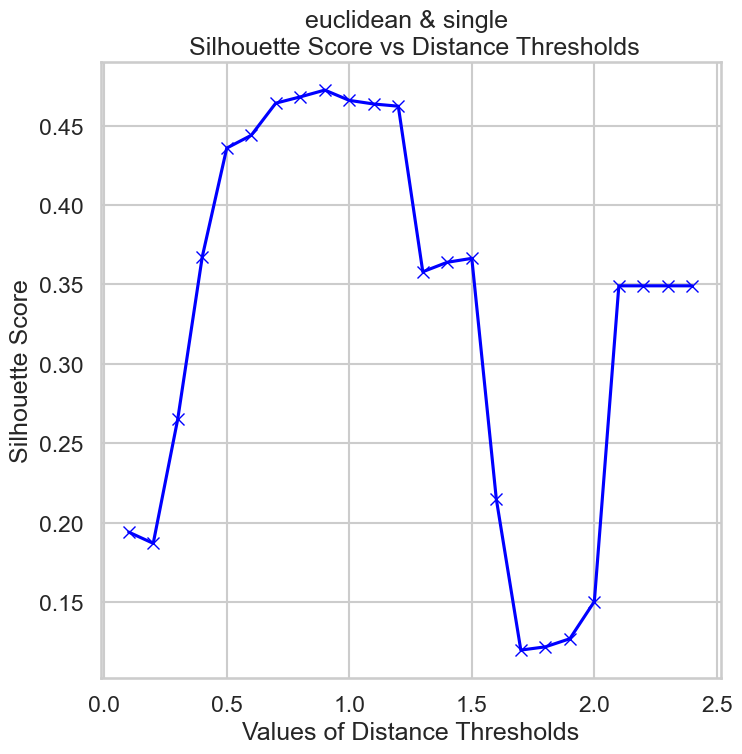

Optimum distance threshold = 1.6
Number of Clusters = 140
Score = 0.2818543188658067


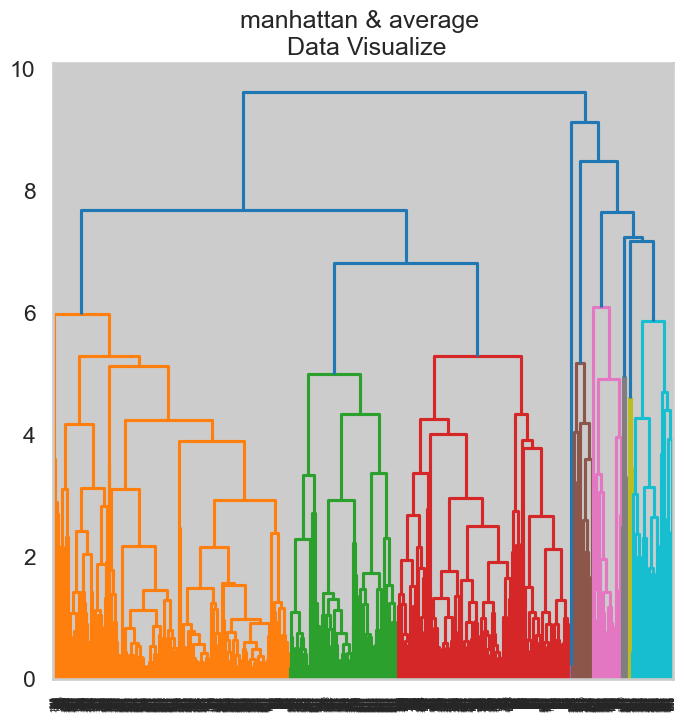

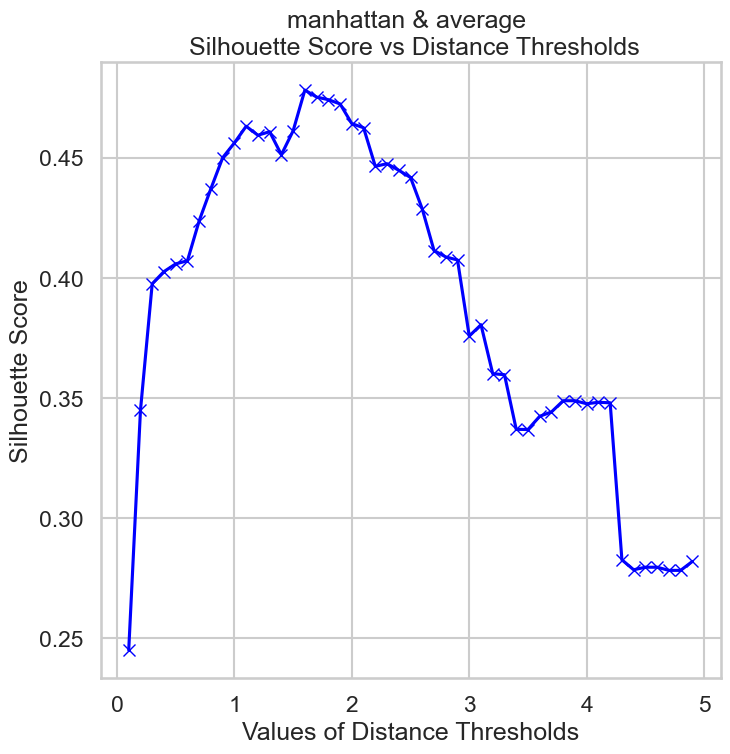

Optimum distance threshold = 1.0
Number of Clusters = 124
Score = 0.34916658225914216


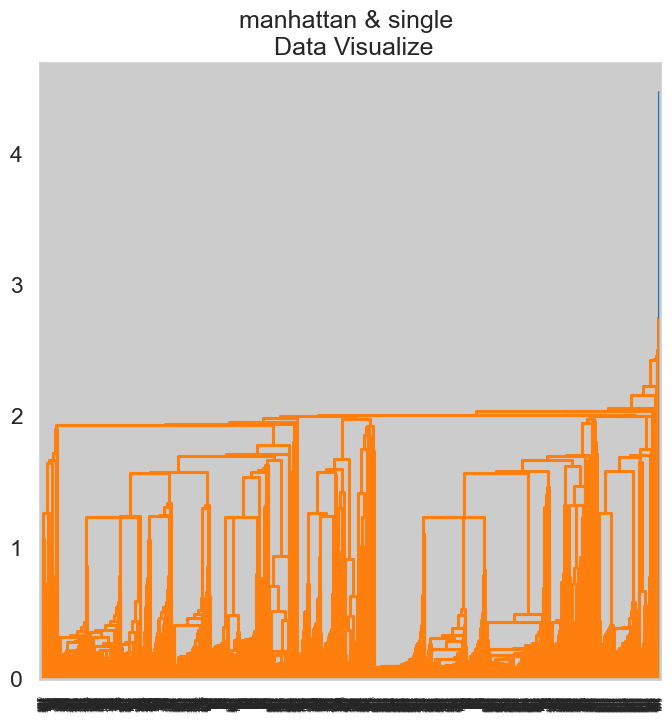

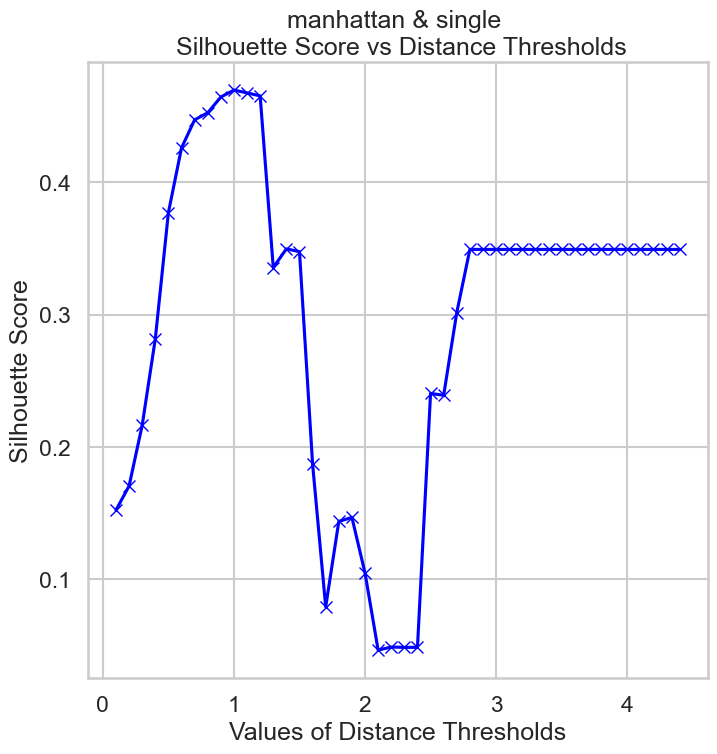

Optimum distance threshold = 0.1
Number of Clusters = 126
Score = 0.22023602771959108


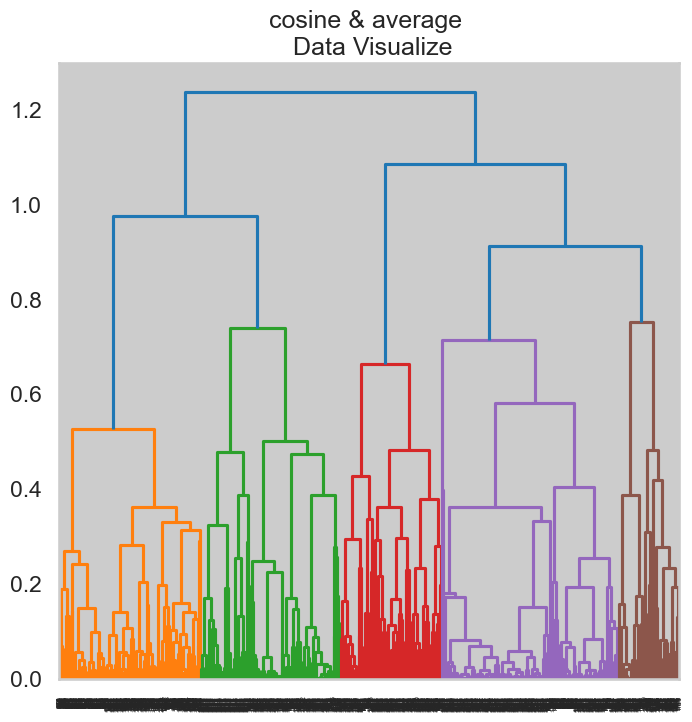

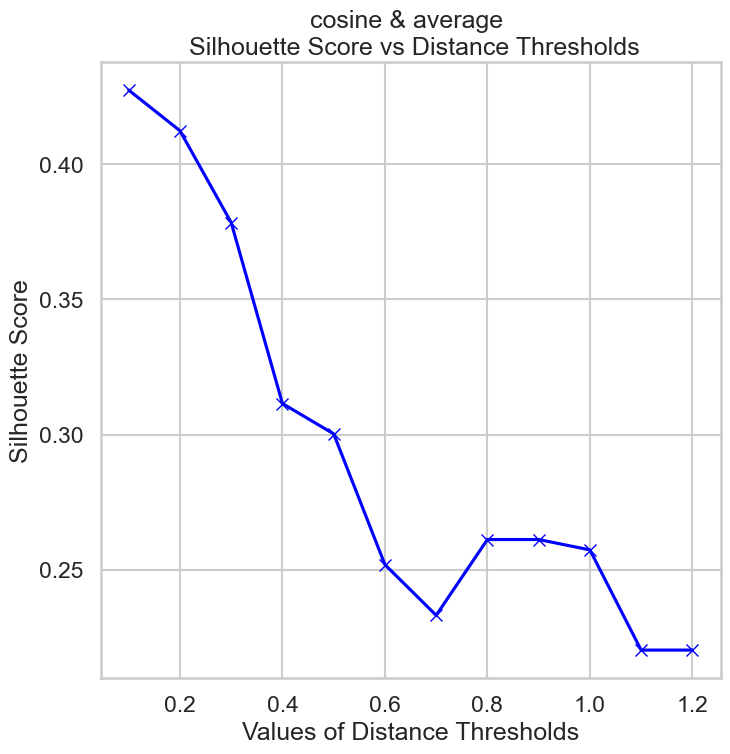

Optimum distance threshold = 0.0322
Number of Clusters = 124
Score = 0.14534041955822222


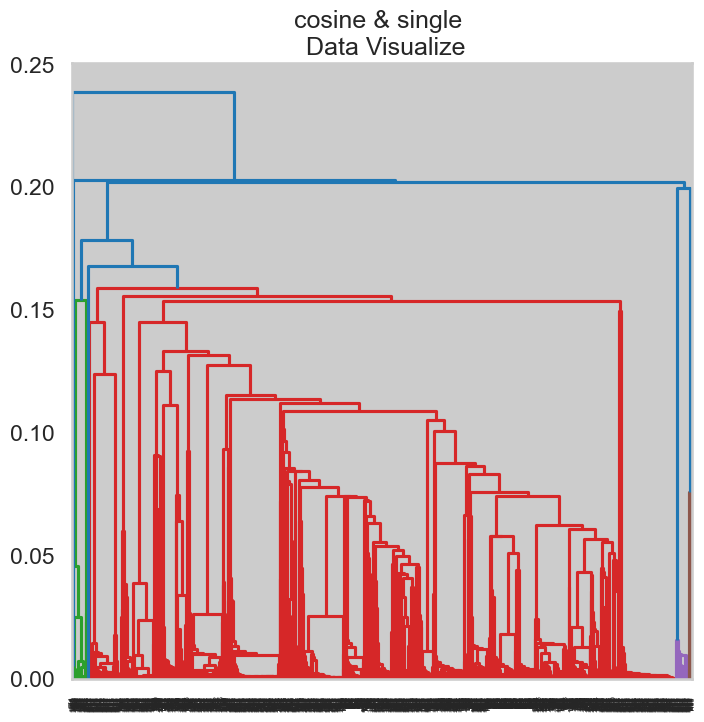

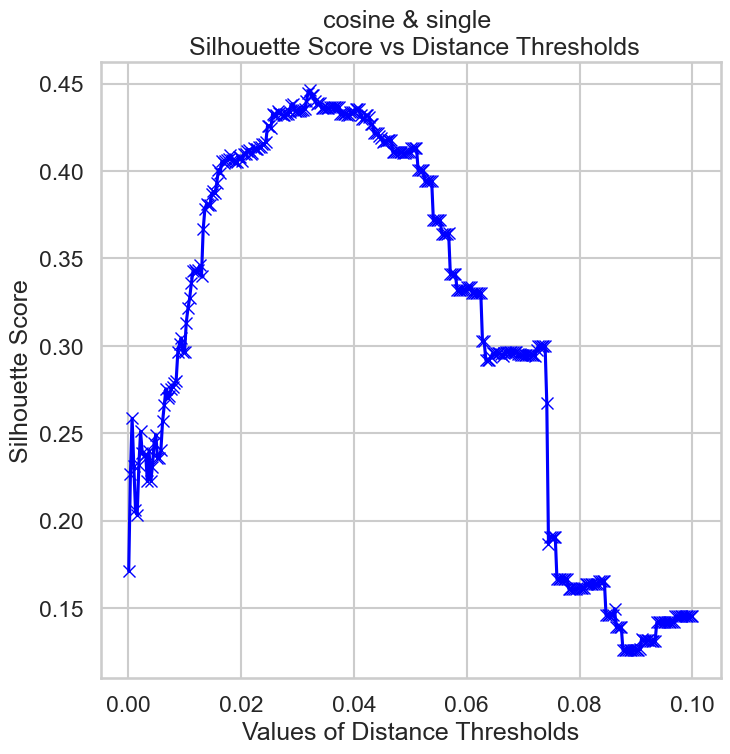

In [27]:
#euclidean & average
[hierarchial_df_score1, hierarchial_df_cluster1, hierarchial_df_best_silhouette1] = hierarchial_method(df, "euclidean", "average")

#euclidean & single
[hierarchial_df_score2, hierarchial_df_cluster2, hierarchial_df_best_silhouette2] = hierarchial_method(df, "euclidean", "single")

#manhattan & average
[hierarchial_df_score3, hierarchial_df_cluster3, hierarchial_df_best_silhouette3] = hierarchial_method(df, "manhattan", "average")

#manhattan & single
[hierarchial_df_score4, hierarchial_df_cluster4, hierarchial_df_best_silhouette4] = hierarchial_method(df, "manhattan", "single")

#cosine & average
[hierarchial_df_score5, hierarchial_df_cluster5, hierarchial_df_best_silhouette5] = hierarchial_method(df, "cosine", "average")

#cosine & single
[hierarchial_df_score6, hierarchial_df_cluster6, hierarchial_df_best_silhouette6] = hierarchial_method(df, "cosine", "single")

### DBScan

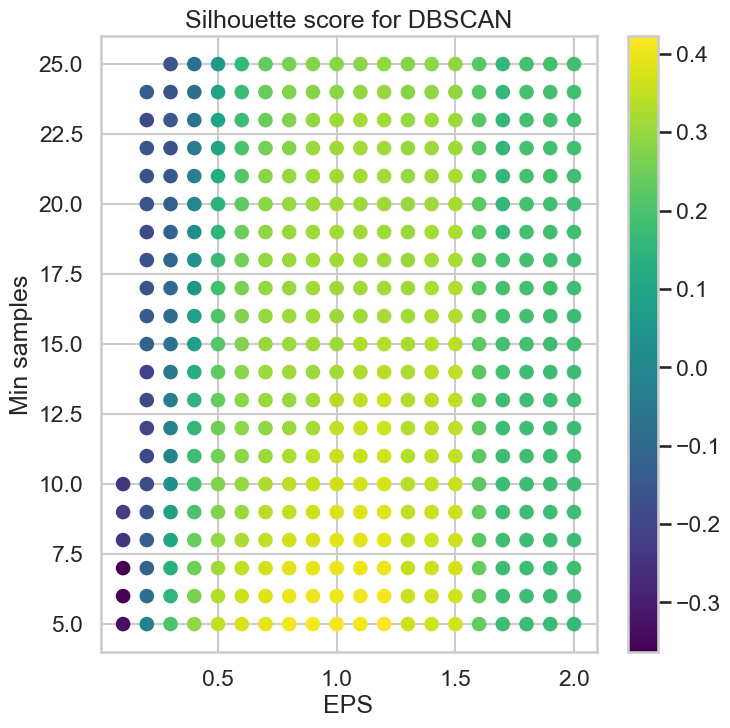

The best silhouette score is 0.423 with eps=1.2 and min_samples=5


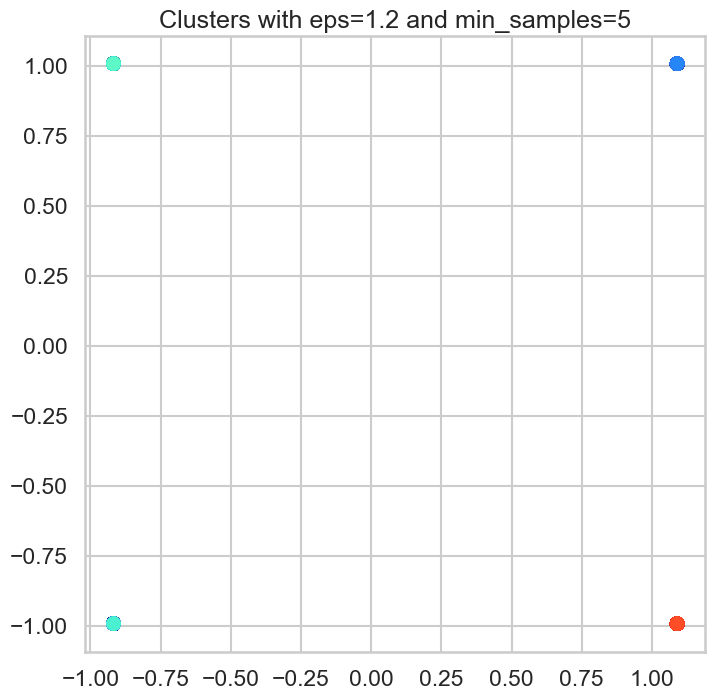

In [28]:
DBScan_method(df)

### Gaussian Mixture

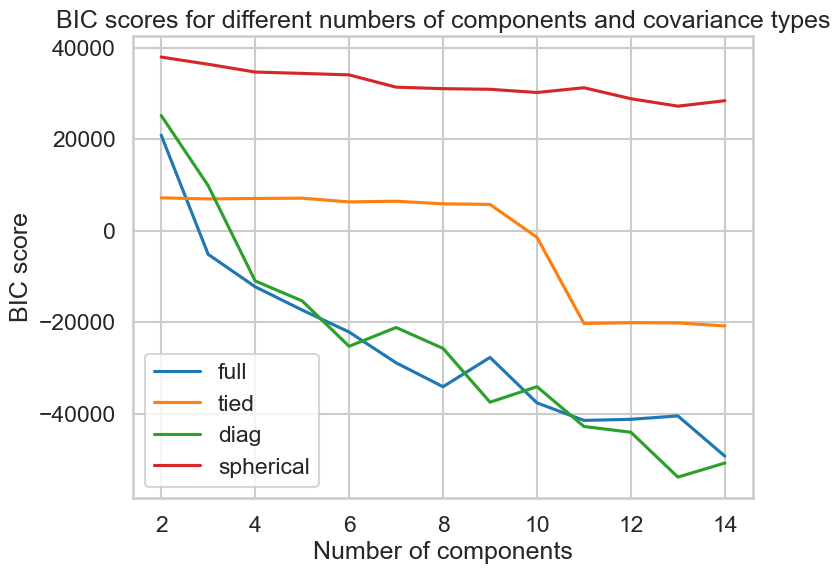

In [29]:
gaussian_method(df)